# Group #24

| STUDENT | ID | EMAIL |
| :-: | :-: | :-: |
| Francesco Lazzari | 1917922 |  lazzari.1917922@studenti.uniroma1.it |
| Sohrab Seyyedi Parsa | 2101087 | seyyediparsa.2101087@studenti.uniroma1.it | 
| Adilkhan Bakridenov | 2105666 | bakridenov.2105666@studenti.uniroma1.it |
| Alba Perna Lotina | 2116863 | pernalotina.2116863@studenti.uniroma1.it |

# Setup

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from collections import Counter
from typing import List, Dict, Tuple
import heapq
from timeit import default_timer as timer

import ijson
import time
import csv
import matplotlib.pyplot as plt
from itertools import zip_longest
import seaborn as sns
from prettytable import PrettyTable
import matplotlib.patches as mpatches
from itertools import count

# Import our functions for bonus point
from functions import mse, score_check
# Import out functions for backend
from functions import shortest_ordered_walk, extract_graph_data,  node_contribution, disconnecting_graphs, extract_communities
# Import our functions for visualization
from functions import visualize_graph_data, visualize_node_contribution, visualize_shortest_path, print_community_table, plot_communities

### Importing the dataset

In [ ]:
# Since the dataset is quite large, we decided to download it directly to the google drive and work on it with Colab
# The following couple of cells are the steps for doing so.
from google.colab import files
files.upload()  # here we upload the key received from Kaggle to communicate with, sth like the pair key of Amazon services

In [ ]:
# Create the directory ~/.kaggle if it does not exist, including any necessary parent directories
!mkdir -p ~/.kaggle

# Copy the file 'kaggle.json' to the ~/.kaggle/ directory
!cp kaggle.json ~/.kaggle/

# Change the permissions of the 'kaggle.json' file to make it readable and writable
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset from kaggle directly to google drive
!kaggle datasets download -d mathurinache/citation-network-dataset -p '/content/drive/MyDrive/ADM'

100% 4.19G/4.19G [01:01<00:00, 57.0MB/s]
100% 4.19G/4.19G [01:01<00:00, 73.7MB/s]


In [ ]:
# Unzip the dataset
!unzip -q '/content/drive/MyDrive/ADM/citation-network-dataset.zip' -d '/content/drive/MyDrive/ADM'

# 1. Data 

In this homework, you will work on a dataset that contains information about a group of papers and their citation relationships. You can find and download the dataset [here](https://www.kaggle.com/datasets/mathurinache/citation-network-dataset)

### Graphs setup 
Based on the available data, you will create two graphs to model our relationships as follows: 

1. __Citation graph__: This graph should represent the paper's citation relationships. We want this graph to be unweighted and directed. The citation should represent the citation given from one paper to another. For example, if paper A has cited paper B, we should expect an edge from node A to B.

2. __Collaboration graph__: This graph should represent the collaborations of the paper's authors. This graph should be weighted and undirected. Consider an appropriate weighting scheme for your edges to make your graph weighted.

### Data pre-processing 

The dataset is quite large and may not fit in your memory when you try constructing your graph. So, what is the solution? You should focus your investigation on a subgraph. You can work on the most connected component in the graph. However, you must first construct and analyze the connections to identify the connected components. 

As a result, you will attempt to approximate that most connected component by performing the following steps: 
1. Identify the __top 10,000__ papers with the <ins>highest number of citations</ins>.
2. Then the __nodes__ of your graphs would be as follows:

   __Citation graph__: you can consider each of the papers as your nodes

   __Collaboration graph__: the authors of these papers would be your nodes
    
3. For the __edges__ of the two graphs, you would have the following cases:
   
   __Citation graph__: only consider the citation relationship between these 10,000 papers and ignore the rest.
   
   __Collaboration graph__: only consider the collaborations between the authors of these 10,000 papers and ignore the rest. 

We used a couple of approaches to read the data. We used pyspark library, chunking approach with pandas, and even ijson library alone, but we did not succeed to read the dataset. So, consulting the web, we found out the following approach which is as follows:
We created a CSV file with the corresponding column names (the ones we want to read from the dataset). Then, we read the dataset with ijson library which is for handling large json files. Since the instances in the dataset have dictionary data structure, we used csv.DictWriter method to grab each instance and write it into the CSV file. We should note that we iterate over dataset instances (or say rows, samples, etc.) using ijson.items method.
We also did some pre-processing tasks like handling missing values and seperating items with multiple values (e.g. authors' name, id, and origin) which were saved all in one dictionary value.
At the end, you can see the time it took to read and process the dataset accordingly.
### Note: Using this approach, we were able to read all the ~ 4.5 million elements of the dataset.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# Define the path for the JSON file
json_file_path = '/content/drive/MyDrive/ADM/ADM_HW5/dblp.v12.json'

# Define the path for the CSV file to be created
csv_file_path = "/content/drive/MyDrive/ADM/ADM_HW5/json_to_csv.csv"

# Record the start time to measure processing time
start = time.process_time()

# Initialize a counter for the number of processed items
count = 0

# Open the JSON file in binary mode and the CSV file in write mode
with open(json_file_path, "rb") as f, open(csv_file_path, "w", newline="") as csvfile:

    # Define the field names for the CSV file
    fieldnames = ['id', 'title', 'year', 'author_name', 'author_org', 'author_id',
                  'n_citation', 'venue_id', 'reference_count', 'references', 'doc_type']

    # Create a CSV DictWriter object with specified fieldnames and set escapechar to handle special characters
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames, escapechar='\\')

    # Write the header row to the CSV file
    writer.writeheader()

    # Iterate over items in the JSON file using ijson library
    for i, element in enumerate(ijson.items(f, "item")):

        # Here we only extract the columns needed to create the Graphs, which helps to decrease the size of the dataset too
        # Initialize a dictionary to store information about the current paper
        paper = {}

        # Extract and store the 'id' of the paper
        paper['id'] = element['id']

        # Extract and store the 'title' of the paper, handle missing titles with NaN
        title = element.get('title')
        if title:
          paper['title'] = title
        else:
          paper['title'] = np.nan

        # Extract and store the 'year' of the paper, handle missing years with NaN
        year = element.get('year')
        if year:
            paper['year'] = year
        else:
            paper['year'] = np.nan

        # Extract and store information about authors, handling missing authors with NaN
        author = element.get('authors')
        if author:
          Author = element['authors']
          author_name = []
          author_org = []
          author_id = []

          # Iterate over author information and store in separate lists
          for i in Author:
            author_name.append(str(i.get('name', np.nan)))
            author_id.append(str(i.get('id', np.nan)))
            author_org.append(str(i.get('org', np.nan)))

          # Join lists into strings and store in the dictionary
          paper['author_name'] = ';'.join(author_name)
          paper['author_org'] = ';'.join(author_org)
          paper['author_id'] = ';'.join(author_id)

        # Extract and store the 'n_citation' count, handle missing values with NaN
        n_citation = element.get('n_citation')
        if n_citation:
            paper['n_citation'] = n_citation
        else:
            paper['n_citation'] = np.nan

        # Extract and store information about the 'venue', handling missing values with NaN
        venue = element.get('venue')
        if venue:
          if 'id' in venue:
            paper['venue_id'] = str(venue['id'])
          else:
            paper['venue_id'] = np.nan

        # Extract and store information about 'references', handling missing values with NaN
        references = element.get('references')
        if references:
          paper['reference_count'] = len(references)
          paper['references'] = ';'.join(str(int(r)) for r in references)
        else:
            paper['references'] = np.nan

        # Extract and store the 'doc_type', handle missing values with NaN
        doc_type = element.get('doc_type')
        if doc_type:
            paper['doc_type'] = doc_type
        else:
            paper['doc_type'] = np.nan

        # Increment the counter
        count += 1

        # Write the paper information to the CSV file
        writer.writerow(paper)

# Print the processing time information
print(f"Reading {count} items of the dataset took almost {round((time.process_time() - start) / 60, 0)} minutes.")

Reading 4894081 items of the dataset took almost 16.0 minutes.


After saving the dataset sa a csv file, we used it to create a pandas dataframe and extract the top 10000 papers with highest number of citations and saved as H_citations_df dataframe.

In [ ]:
# Read the CSV and convert it into a pandas dataframe
csv_file_path = "/content/drive/MyDrive/ADM/ADM_HW5/json_to_csv.csv"
papers_df = pd.read_csv(csv_file_path)
papers_df.head()

,id,title,year,author_name,author_org,author_id,n_citation,venue_id,reference_count,references,doc_type
0,1091,Preliminary Design of a Network Protocol Learn...,2013.0,Makoto Satoh;Ryo Muramatsu;Mizue Kayama;Kazuno...,Shinshu University;Shinshu University;Shinshu ...,2312688602;2482909946;2128134587;2101782692;21...,1.0,1.127420e+09,2.0,2005687710;2018037215,Conference
1,1388,Further Results on Independence in Direct-Prod...,2000.0,Pranava K. Jha,NaN,2718958994,1.0,7.315869e+07,NaN,NaN,Journal
2,1674,A methodology for the physically accurate visu...,2011.0,G. Beale;G. Earl,"Archaeological Computing Research Group, Unive...",2103626414;2117665592,1.0,2.754954e+09,15.0,1535888970;1992876689;1993710814;2035653341;20...,Conference
3,1688,"Comparison of GARCH, Neural Network and Suppor...",2009.0,Altaf Hossain;Faisal Zaman;M. Nasser;M. Mufakh...,"Department of Statistics , Rajshahi University...",2300589394;2308774408;2126056503;2425818370,6.0,1.136275e+09,3.0,1560724230;1986968751;2156909104,Conference
4,5411,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,2009.0,Rafael Álvarez;Leandro Tortosa;José-Francisco ...,nan;nan;nan;nan,2125293936;2101693188;2159120860;2146570697,NaN,1.136213e+09,NaN,NaN,Conference


In [ ]:
# Identifying the top 10,000 papers with the highest number of citations
H_citations_df = papers_df.nlargest(10000,columns= 'n_citation')
H_citations_df.tail()

,id,title,year,author_name,author_org,author_id,n_citation,venue_id,reference_count,references,doc_type
1923662,2083658929,A graph-based system for network-vulnerability...,1998.0,Cynthia Phillips;Laura Painton Swiler,"Sandia National Laboratories, MS 1110, Albuque...",2304586826;423391057,596.0,1.197584e+09,11.0,163879073;1497494381;1964549039;1986538507;199...,Conference
2014229,2093212899,Simultaneous structure and texture image inpai...,2003.0,M. Bertalmio;L. Vese;G. Sapiro;S. Osher,"Dept. de Tecnologia, Univ. of Pompeu-Fabra, Ba...",1977013097;335205715;2114921128;2241451362,596.0,1.153046e+08,22.0,1488881187;1565233179;1569587969;1983661653;19...,Journal
2109151,2101699859,Countering code-injection attacks with instruc...,2003.0,Gaurav S. Kc;Angelos D. Keromytis;Vassilis Pre...,Columbia University;Columbia University;Drexel...,1974600515;299775663;282527274,596.0,1.198471e+09,42.0,186343359;1481758559;1499992849;1508969946;151...,Conference
2244256,2113724293,Geometric-optical bidirectional reflectance mo...,1992.0,X. Li;A.H. Strahler,"Center for Remote Sensing, Boston Univ., MA, U...",2983290360;2306594382,596.0,1.113267e+08,NaN,NaN,Journal
2248784,2114129195,Blind Multiband Signal Reconstruction: Compres...,2009.0,M. Mishali;Y.C. Eldar,"Technion-Israel Institute of Technology, Haifa...",313873513;193178368,596.0,1.686803e+08,24.0,8251247;72543818;1567375197;1974774078;1986931...,Journal


Here, we did some investigations about the data regarding the Data pre-processing.

In [ ]:
# If there is any missing data in column 'id'
pd.isna(H_citations_df['id']).any()

False

In [ ]:
# If there is any missing data in column 'year'
pd.isna(H_citations_df['year']).any()

False

In [ ]:
# If there is any missing data in column 'doc_type'
pd.isna(H_citations_df['doc_type']).any()

True

In [ ]:
# If there is any missing data in column 'references'
pd.isna(H_citations_df['references']).any()

True

## Graphs setup

Now, using the H_citations_df dataframe, we created the Citation and Collaboration graphs, respectively. As requested, for Citation graph we considered each of the papers as the nodes and the citation relationship between these 10,000 papers as its edges. Also, for the Collaboration graph we considered the authors of these papers as the nodes, and the collaborations between the authors of these 10,000 papers as the edges.

### Building the Citation graph

In [ ]:
# Create a directed-unweighted graph for the Citation graph
Citation_G = nx.DiGraph()

# Add nodes and edges to the graph
for _, row in H_citations_df.iterrows():
    paper_id = row['id']
    paper_type = str(row['doc_type'])

    # Add source node with each of the papers as nodes
    Citation_G.add_node(paper_id, paper_year = int(row['year']))
    # Add attributes to the nodes
    if paper_type != 'nan':
        Citation_G.nodes()[paper_id]['paper_type'] = paper_type

for _, row in H_citations_df.iterrows():
    paper_id = row['id']
    references = str(row['references'])

    # Add edges from source to references
    if references != 'nan':
        for reference in references.split(';'):
            # Check if the referenced node already exists
            if Citation_G.has_node(int(reference)):
                Citation_G.add_edge(paper_id, int(reference))

In [ ]:
# If the lenght of nodes of the graph is equal to the lenght of our selected dataset
len(Citation_G.nodes()) == len(H_citations_df)

True

In [ ]:
len(Citation_G.edges())

52253

In [ ]:
# Checking
refs = H_citations_df['references'].dropna()
num_ref = 0
for ref in refs:
  num_ref += len(ref.split(';'))

print(num_ref)

187856


In [ ]:
Citation_G.nodes[2151103935]

{'paper_year': 2004, 'paper_type': 'Journal'}

In [ ]:
# Comparing for a given node sample, the references exist in the dataset and the connections exist in the graph
graph_neighbors = list(Citation_G.successors(2151103935))

references_str = H_citations_df.loc[H_citations_df['id'] == 2151103935]['references'].values[0]
dataset_references = [int(ref) for ref in references_str.split(';')]

all(element in dataset_references for element in graph_neighbors)

True

In [ ]:
Citation_G.number_of_edges(2151103935, 2427881153)

1

In [ ]:
str(H_citations_df.loc[H_citations_df['id'] == 1639032689]['author_org'].values[0]) == 'nan'

True

In [ ]:
# If there is any missing data in column 'author_name'
pd.isna(H_citations_df['author_name']).any()

False

In [ ]:
# If there is any missing data in column 'author_id'
pd.isna(H_citations_df['author_id']).any()

False

In [ ]:
# If there is any missing data in column 'author_org'
pd.isna(H_citations_df['author_org']).any()

True

In [ ]:
# Checking whether there exists author_id for every author_name in the corresponding columns
sum(H_citations_df.apply(lambda row: len(row['author_id'].split(';')) == len(row['author_name'].split(';')), axis=1).values) == len(H_citations_df)

True

### Building the Collaboration graph

In [ ]:
# Create an undirected-weighted graph for the Collaboration graph
Collaboration_G = nx.Graph()

# Add nodes to the graph which are authors of these papers
for _, row in H_citations_df.iterrows():
    author_names = str(row['author_name']).split(';')
    author_ids = str(row['author_id']).split(';')
    author_orgs = str(row['author_org']).split(';')

    # Use zip_longest to fill missing values with 'nan'
    for id, author, org in zip_longest(author_ids, author_names, author_orgs, fillvalue='nan'):
        if not Collaboration_G.has_node(author):
            Collaboration_G.add_node(id, name=author)
            if org != 'nan':
                Collaboration_G.nodes[id]['org'] = org

# Add edges to the graph
for _, row in H_citations_df.iterrows():
    author_ids = str(row['author_id']).split(';')

    for i in range(len(author_ids)):
        for j in range(i + 1, len(author_ids)):

            # Check if edge already exists, and update the weight
            if Collaboration_G.has_edge(author_ids[i], author_ids[j]):
                Collaboration_G[author_ids[i]][author_ids[j]]['weight'] += 1
                Collaboration_G[author_ids[i]][author_ids[j]]['titles'] += [row['title']]

            else:
                Collaboration_G.add_edge(author_ids[i], author_ids[j], weight=1)
                Collaboration_G[author_ids[i]][author_ids[j]]['titles'] = [row['title']]

In [ ]:
len(Collaboration_G.nodes())

21233

In [ ]:
# Extracting the number of all authors
all_ids = set()

for row in H_citations_df['author_id']:
    all_ids.update(str(row).split(';'))

In [ ]:
# Where is the missing one :D
len(all_ids)

21232

In [ ]:
# A sample of the graph node
Collaboration_G.nodes()['1977013097']

{'name': 'M. Bertalmio',
 'org': 'Dept. de Tecnologia, Univ. of Pompeu-Fabra, Barcelona, Spain'}

In [ ]:
Collaboration_G['1977013097']

AtlasView({'2114921128': {'weight': 3, 'titles': ['Image inpainting', 'Navier-stokes, fluid dynamics, and image and video inpainting', 'Simultaneous structure and texture image inpainting']}, '2102808662': {'weight': 1, 'titles': ['Image inpainting']}, '2108631596': {'weight': 1, 'titles': ['Image inpainting']}, '692166387': {'weight': 1, 'titles': ['Navier-stokes, fluid dynamics, and image and video inpainting']}, '335205715': {'weight': 1, 'titles': ['Simultaneous structure and texture image inpainting']}, '2241451362': {'weight': 1, 'titles': ['Simultaneous structure and texture image inpainting']}})

In [ ]:
len(Collaboration_G.edges())

136476

# 2. Controlling system

Please keep the following in mind for both the backend and frontend components. The plan is to put in place a control system. You will provide the user with a menu from which he can select different functionalities. The user should be able to select from one of five different functionalities that you will implement in the following two sections. We want to have such a system so that the user can query different functionalities that he is interested in. 

Your function should be designed in such a way that it provides the most flexibility to the user. For example, when the user selects functionality 1, which provides some high-level information about the graph, you can allow him to pass an argument indicating which of the two types of graphs he wants to be analyzed (That is why the name of the graph is one of the arguments in the first functionality). 

You will implement the functionalities in the Backend section. The Frontend section primarily discusses the menu that you must provide to the user, as well as the expected results that should be displayed to the user after selecting each of the functionalities. 

## 2.1. Backend Implementation
This section describes what each of the functionalities should be. 

### Functionality 1 - Graph's features
This function should examine a graph and report on some of its features. The input and report that this function should produce are shown below. 

Input: 
- The graph
- The name of the graph

Output: 
- The number of the nodes in the graph
- The number of the edges in the graph
- The graph density
- The graph degree distribution
- The average degree of the graph
- The graph hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
- Whether the graph is dense or sparse

---

The steps followed for this feature are outlined in the `extract_graph_data` function located in the `functions.py` file of the repository, which has comprehensive code comments.

In [ ]:
# Extract the features for the Citation Graph
citation_data = extract_graph_data(Citation_G, "Citation_Graph")
citation_data

In [ ]:
# Extract the features for the Collaboration Graph
collaboration_data = extract_graph_data(Collaboration_G, "Collaboration_Graph")
collaboration_data

### Functionality 2 - Nodes' contribution 
Using this functionality, you will identify the papers/authors who have significantly contributed to this field of study. For this analysis, focusing solely on the number of citations for the paper or the number of collaborations of the authors can be misleading. You will examine this using various centrality measurements. 

Input:
- The graph
- A node of the graph (paper/author)
- The name of the graph

Output: 
- The centrality of the node, calculated based on the following centrality measurements:
   - [Betweeness](https://www.tandfonline.com/doi/abs/10.1080/0022250X.2001.9990249)
   - [PageRank](https://courses.cs.washington.edu/courses/cse373/17au/project3/project3-3.html)
   - [ClosenessCentrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality)
   - DegreeCentrality

---

The steps followed for this feature are outlined in the `node_contribution` function located in the `functions.py` file of the repository, which has comprehensive code comments.

In [ ]:
# compute the node contribution for an example node
node_centrality = node_contribution(Citation_G, 2083658929, "Citation Graph")
node_centrality

{'Node': 2083658929,
 'Graph': 'Citation Graph',
 'Betweenness Centrality': 1.4254275997713796e-07,
 'PageRank': 4.715246115495467e-05,
 'Closeness Centrality': 0.00010001000100010001,
 'Degree Centrality': 0.00030003000300030005}

### Functionality 3 - Shortest ordered walk  

Input:  
- The graph data 
- A sequence of authors\_a = [a\_2, ..., a\_{n-1}]
- Initial node a\_1 and an end node a\_n
- $N$: denoting the top $N$ authors whose data should be considered
 
Output: 
- The shortest walk of collaborations you need to read to get from author a\_1 to author a\_n and the papers you need to cross to realize this walk.
 
Considerations: 
For this functionality, you must implement an algorithm that returns the shortest __walk__ that goes from node a\_j to a\_n, which visits **in order** the nodes in _a_. The choice of a\_j and a\_n can be made randomly (or if it improves the performance of the algorithm, you can also define it in any other way) 

__Important Notes:__
- This algorithm should be run only on the collaboration graph.
- The algorithm needs to handle the case that the graph is not connected. Thus, only some nodes in _a_ are reachable from a\_1. In such a scenario, it is enough to let the program give in the output the string "There is no such path."
- Since we are dealing with walks, you can pass on the same node _a\_i_ more than once, but you must preserve order. It means you can go back to any author node any time you want, assuming that the order in which you visit the required nodes is still the same.
- Once you completed your implementation, ask chatGPT for a different one leveraging another approach in solving the shortest path and prove whether this implementation is correct. 

---

The steps followed for this feature are outlined in the `shortest_ordered_walk` function located in the `functions.py` file of the repository, which has comprehensive code comments.

In [ ]:
# Find the shortest ordered walk for two example node and two example authors to cross 
result = shortest_ordered_walk(Collaboration_G, ['1984280187', '338444495'], '783371218', '1973035492', 20)
result

{'Shortest Walk': ['783371218', '1984280187', '338444495', '1973035492'],
 'Papers Crossed': ['A promoter-level mammalian expression atlas',
  'A promoter-level mammalian expression atlas',
  'A promoter-level mammalian expression atlas']}

### Functionality 4 - Disconnecting Graphs

Input: 
- The graph data 
- authorA: a paper to which will relate sub-graph G\_a
- authorB: a paper to which will relate sub-graph G\_b
- $N$: denoting the top $N$ authors that their data should be considered

Output:
- The minimum number of edges (by considering their weights) required to disconnect the original graph in two disconnected subgraphs: G\_a and G\_b.

---

The steps followed for this feature are outlined in the `disconnecting_graphs` function located in the `functions.py` file of the repository, which has comprehensive code comments.

In [ ]:
# Disconnect the Collaboration Graph for two sample authors in a max of 10 authors extracted by degree centrality
subgraph, G_a, G_b, num_edges_in_min_cut = disconnecting_graphs(Collaboration_G, '1973035492', '173839695', 10)
print("Number of edges in minimum edge cut:", num_edges_in_min_cut)
print("Subgraph G_a:", G_a)
print("Subgraph G_b:", G_b)

Number of edges in minimum edge cut: 5
Subgraph G_a: {'2111642879', '332422508', '2034164144', '2146468246', '2120643991', '1566488673', '1973035492', '1976452423', '1984280187'}
Subgraph G_b: {'173839695'}


### Functionality 5 - Extracting Communities

Input: 
- The graph data 
- $N$: denoting the top $N$ papers that their data should be considered
- Paper\_1: denoting the name of one of the papers 
- Paper\_2: denoting the name of one of the papers

Output:
- The minimum number of edges that should be removed to form communities
- A list of communities, each containing a list of papers that belong to them.
- Whether the Paper\_1 and Paper\_2 belongs to the same community. 

Important Notes:  
To comprehend this functionality better, we suggest you take a good look at this [article](https://www.analyticsvidhya.com/blog/2020/04/community-detection-graphs-networks/)

---

The steps followed for this feature are outlined in the `extract_communities` function located in the `functions.py` file of the repository, which has comprehensive code comments.

In [ ]:
# Extract Communities from the Citation Graph from the top 50 authors with max degree centrality 
# the chosen authors are random
subgraph, num_edges_to_remove, extracted_communities, same_community = extract_communities(Citation_G, 50, 2165949425, 2096525273)

print(f"Number of edges to remove: {num_edges_to_remove}")
print("Communities:")
for i, community in enumerate(extracted_communities, 1):
    print(f"Community {i}: {list(community)}")
print(f"Paper_1 and Paper_2 belong to the same community: {same_community}")

Number of edges to remove: 1
Communities:
Community 1: [2041404167, 2161969291, 1971784203, 2163605009, 2162915993, 2159080219, 2119821739, 2156909104, 1501500081, 2121947440, 2153635508, 2296616510, 2124386111, 2151103935, 2031489346, 2117539524, 2076063813, 2147152072, 2102605133, 2618530766, 47957325, 2168356304, 1956559956, 2163922914, 2108598243, 2150341604, 1880262756, 2072128103, 1639032689, 2147800946, 2912934387, 2165949425, 1660562555, 1986931325]
Community 2: [2100408980, 1987198869, 1791587663]
Community 3: [2125055259]
Community 4: [2156186849, 1996360405, 1655990431]
Community 5: [2118428193]
Community 6: [2096525273, 2141885858]
Community 7: [2164598857, 1988790447]
Community 8: [2066636486]
Community 9: [2130509920]
Community 10: [2148251644, 2157457404]
Paper_1 and Paper_2 belong to the same community: False


## 2.2. Frontend Implementation 
This section describes how the final results for each functionality implemented in the backend section should be presented to the user. 

Please run __at least one query for each functionality__ in the final version of the notebook and __comment on the results__. 

### Visualization 1 - Visualize graph features 
We anticipate seeing the Functionality 1 report in Visualization 1. To be more specific, we expect you to have the following report format:

 - A table containing the following general information about the graph: 
      - Number of nodes in the graph
      - Number of the edges in the graph 
      - Density of the graph
      - Average degree of the graph
      - Whether the network is sparse or dense 
 - A table that lists the graph's hubs
 - A plot depicting the distribution of the citations received by papers (Citation graph)
 - A plot depicting the distribution of the given citations by papers (Citation graph) 
 - A plot depicting the number of collaborations of the author (Collaboration graph)

__Note:__ You can plot the features for a limited number of nodes (e.g., top 20) to improve the visualization of the plots. 


---

The steps followed for this visualization are outlined in the `visualize_graph_data` function located in the `functions.py` file of the repository, which has comprehensive code comments.

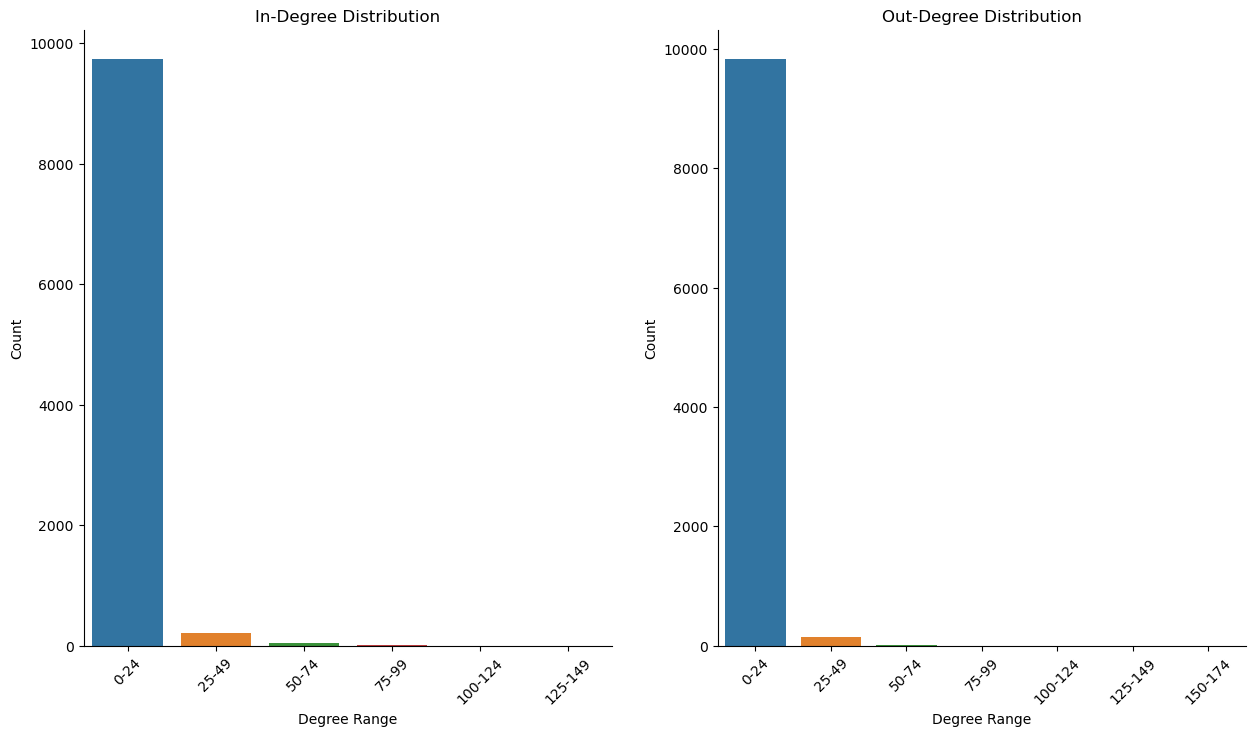

+-----------------------------------------------------------------------------------------+
|                                      Citation_Graph                                     |
+-----------------+-----------------+-----------------------+------------+----------------+
| Number of Nodes | Number of Edges |     Graph Density     | Graph Type | Average Degree |
+-----------------+-----------------+-----------------------+------------+----------------+
|      10000      |      52253      | 0.0005225822582258226 |   sparse   |     5.2253     |
+-----------------+-----------------+-----------------------+------------+----------------+


,Graph Hubs
0,2041404167
1,1639032689
2,2912565176
3,2151103935
4,2911964244
...,...
1678,1827261456
1679,2005624335
1680,2157283388
1681,2295541535


In [ ]:
# Visualize the data of the Citation Graph
visualize_graph_data(citation_data)

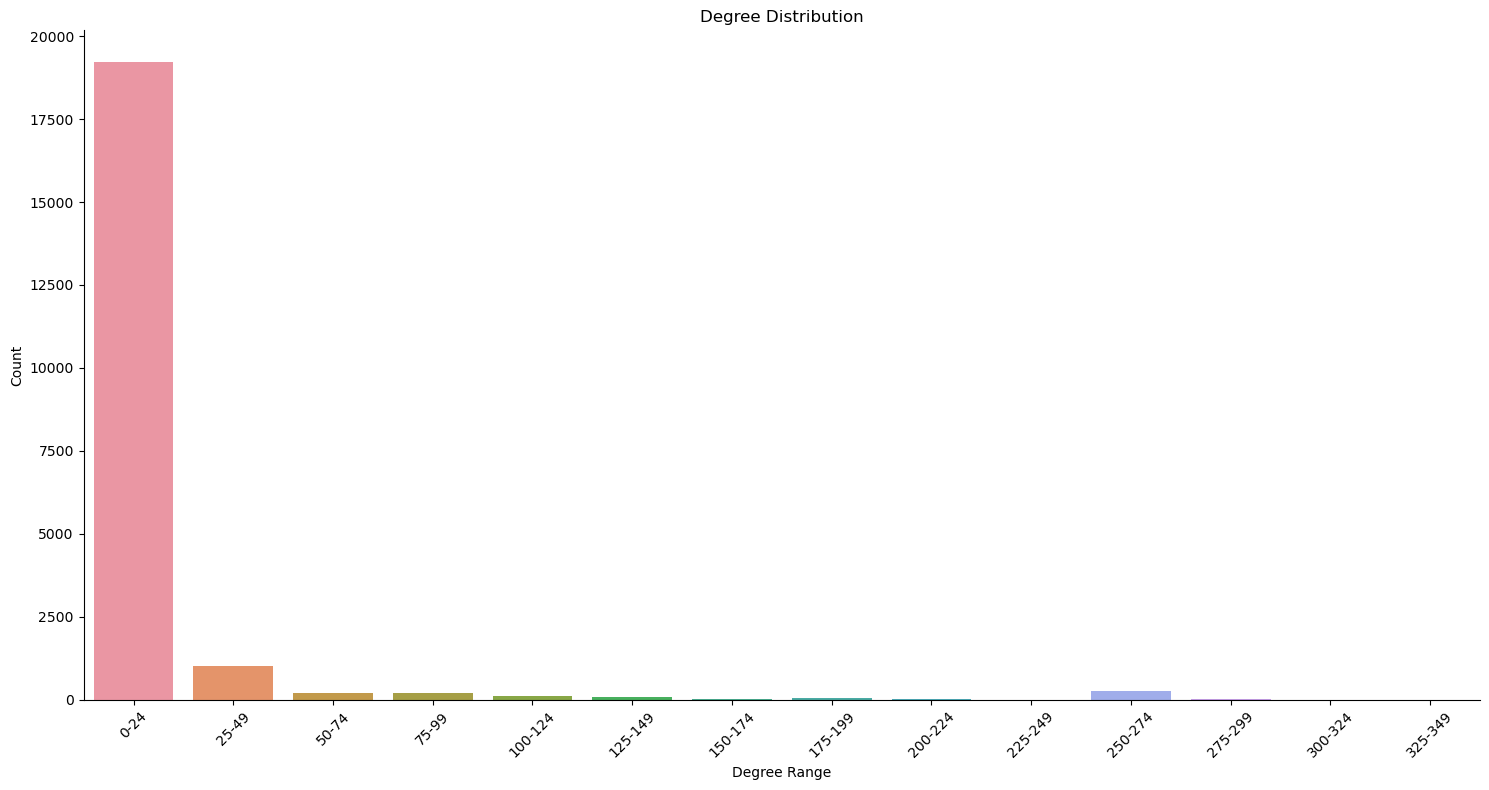

+---------------------------------------------------------------------------------------------+
|                                     Collaboration_Graph                                     |
+-----------------+-----------------+-----------------------+------------+--------------------+
| Number of Nodes | Number of Edges |     Graph Density     | Graph Type |   Average Degree   |
+-----------------+-----------------+-----------------------+------------+--------------------+
|      21233      |      136476     | 0.0006054579911102959 |   sparse   | 12.855084067253802 |
+-----------------+-----------------+-----------------------+------------+--------------------+


,Graph Hubs
0,1445484688
1,2104401652
2,2435751034
3,2007415138
4,2096217197
...,...
1007,2735684164
1008,2734507409
1009,2735498832
1010,2734432318


In [ ]:
# Visualize the data for the Collaboration Graph
visualize_graph_data(collaboration_data)

 ### Visualization 2 - Visualize the node's contribution
We anticipate seeing the Functionality 2 report in Visualization 2. To be more specific, we expect you to have the following report format:

   - A table containing the node's centrality value based on the four centrality measurements

---

The steps followed for this visualization are outlined in the `visualize_node_contribution` function located in the `functions.py` file of the repository, which has comprehensive code comments.

In [ ]:
# Visualize the node contribution for an example node of the Citation Graph
visualize_node_contribution(node_centrality, 2083658929, "Citation Graph")

+-------------------------------------------------------------------------------------------+
|                     Contribution of node 2083658929 in Citation Graph                     |
+------------+------------------------+----------+----------------------+-------------------+
|    Node    | Betweenness Centrality | PageRank | Closeness Centrality | Degree Centrality |
+------------+------------------------+----------+----------------------+-------------------+
| 2083658929 |         0.0000         |  0.0000  |        0.0001        |       0.0003      |
+------------+------------------------+----------+----------------------+-------------------+



 ### Visualization 3 - Visualize the shortest-ordered route 
 We anticipate seeing the Functionality 3 report in Visualization 3. To be more specific, we expect you to have the following report format:
 - Print the papers needed to be crossed in the shortest walk in order 
 - Plot the graph and identify the nodes and edges that appear in the shortest walk (please put an identifier on each edge in the shortest walk to determine the order that we should have the walk)

---

The steps followed for this visualization are outlined in the `visualize_shortest_path` function located in the `functions.py` file of the repository, which has comprehensive code comments.

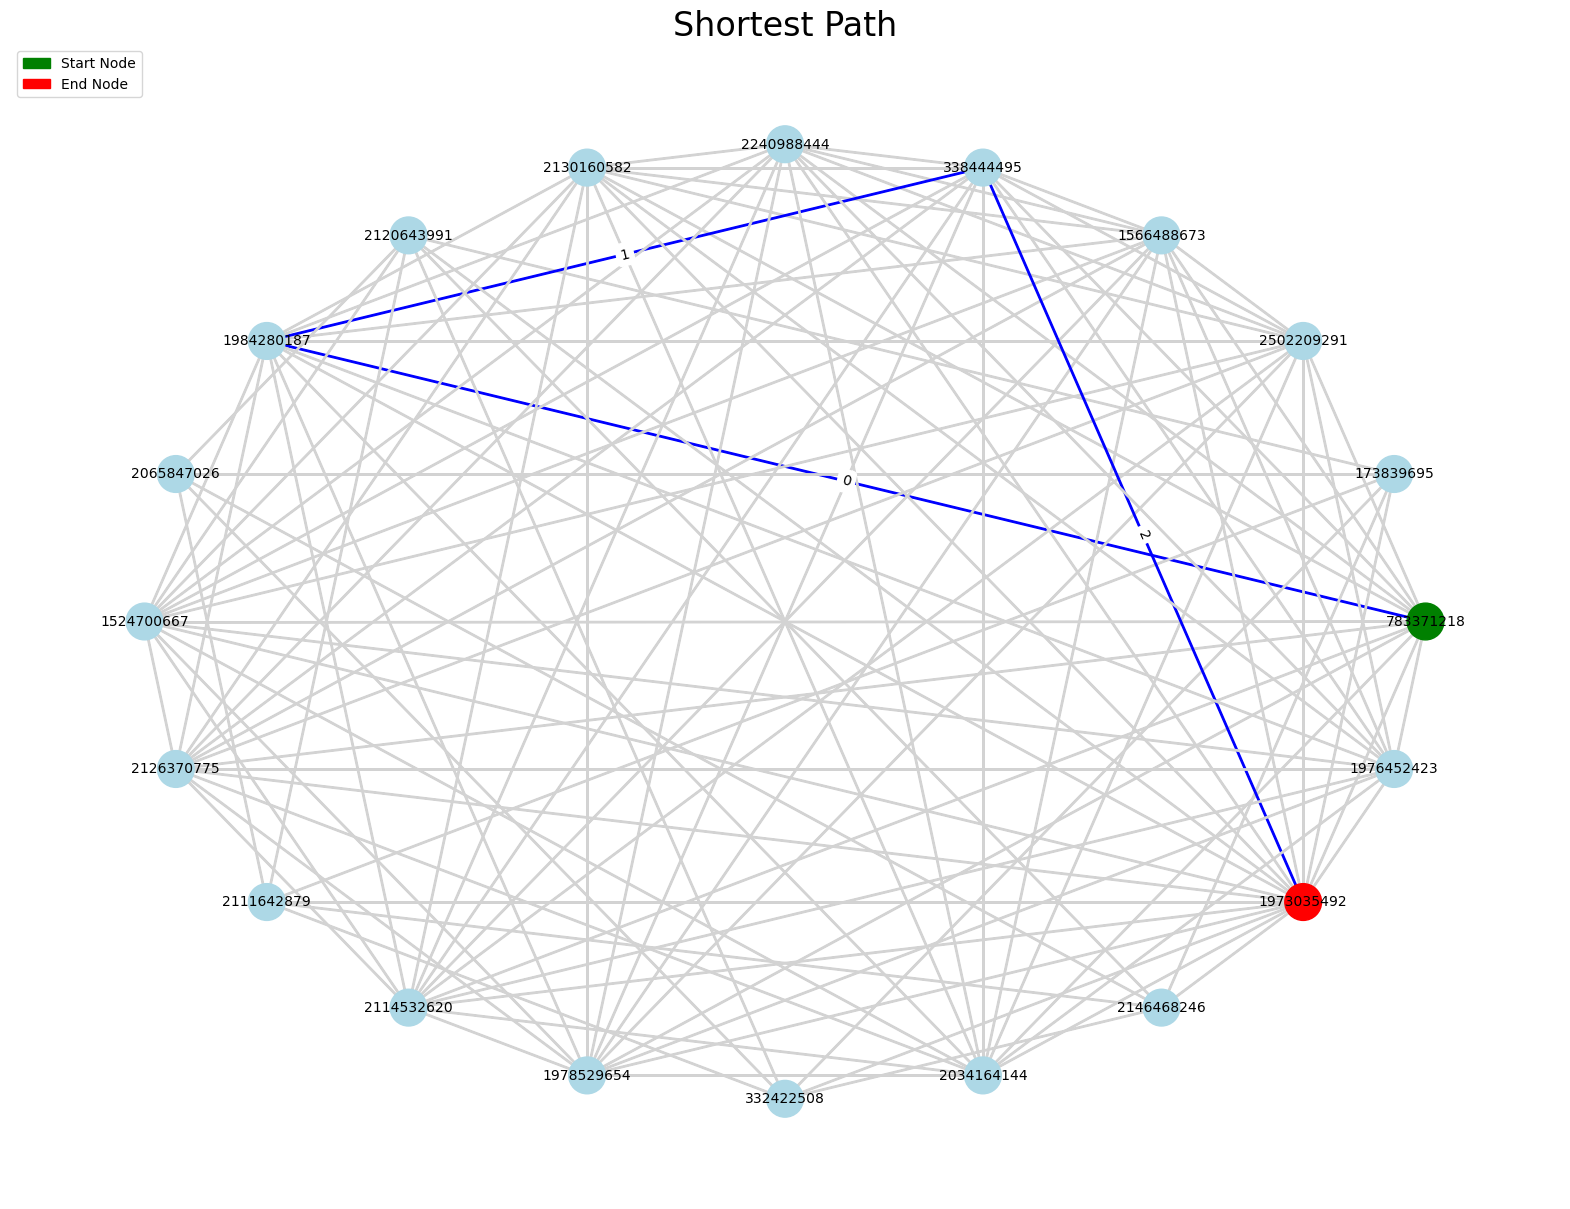

,List of Crossed Papers
0,A promoter-level mammalian expression atlas
1,A promoter-level mammalian expression atlas
2,A promoter-level mammalian expression atlas


In [ ]:
# Visualize the Shortest Path for the two example authors and the two example cross authors 
# from a subgraph of the top 20 authors with most degree centrality
visualize_shortest_path(Collaboration_G, result, N=20)

 ### Visualization 4 - Visualize the disconnected graph 
 We anticipate seeing the Functionality 4 report in Visualization 4. To be more specific, we expect you to have the following report format:
 - Print the number of the links that should be disconnected 
 - Plot the original graph 
 - Plot the graph after removing the links and identify the two nodes

---

The steps followed for this visualization are outlined in the `visualize_disconnected_graph` function located in the `functions.py` file of the repository, which has comprehensive code comments.

Number of links to be disconnected: 5


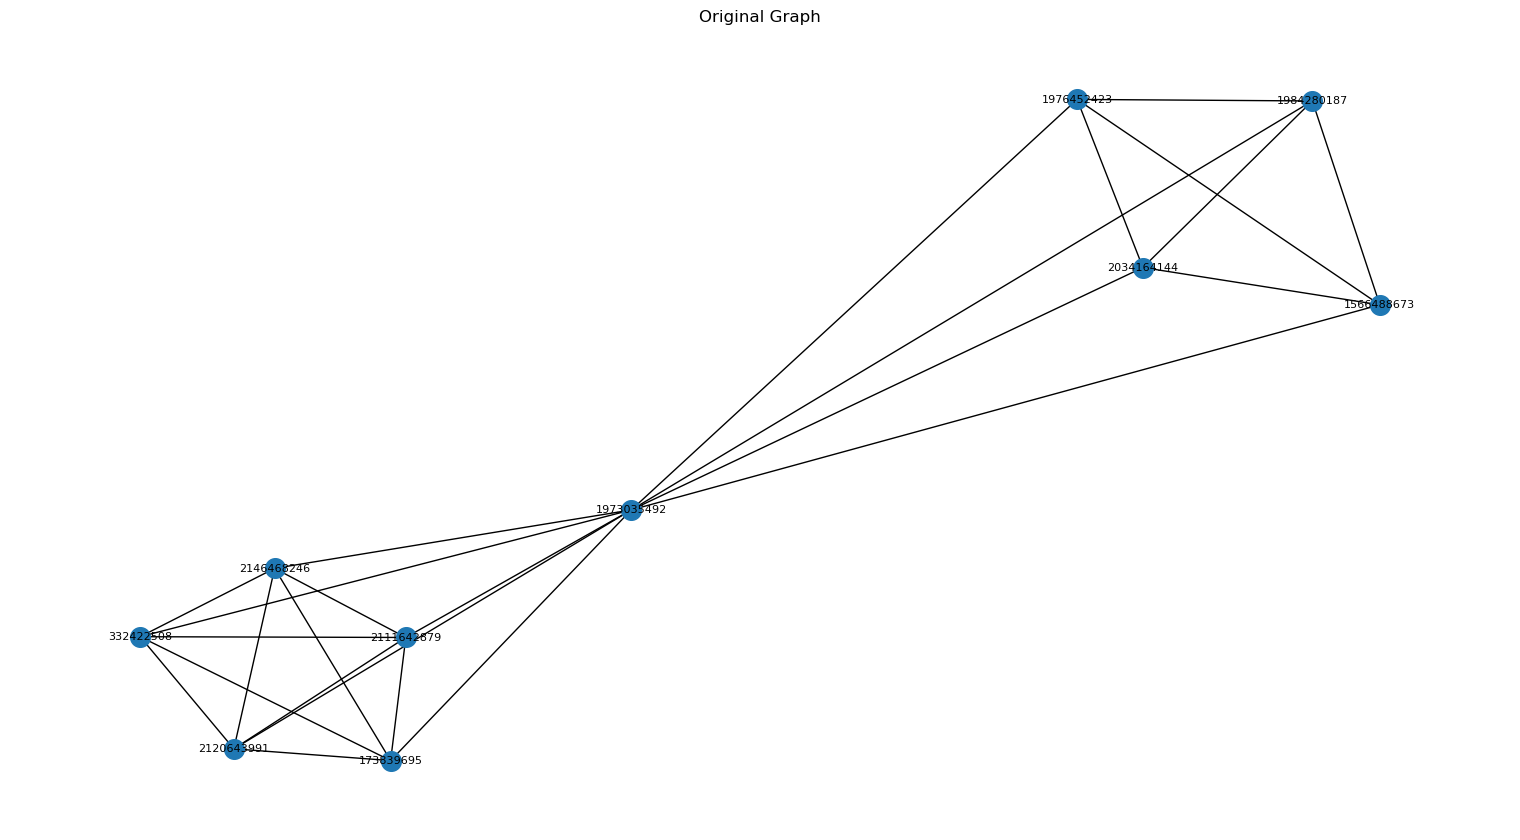

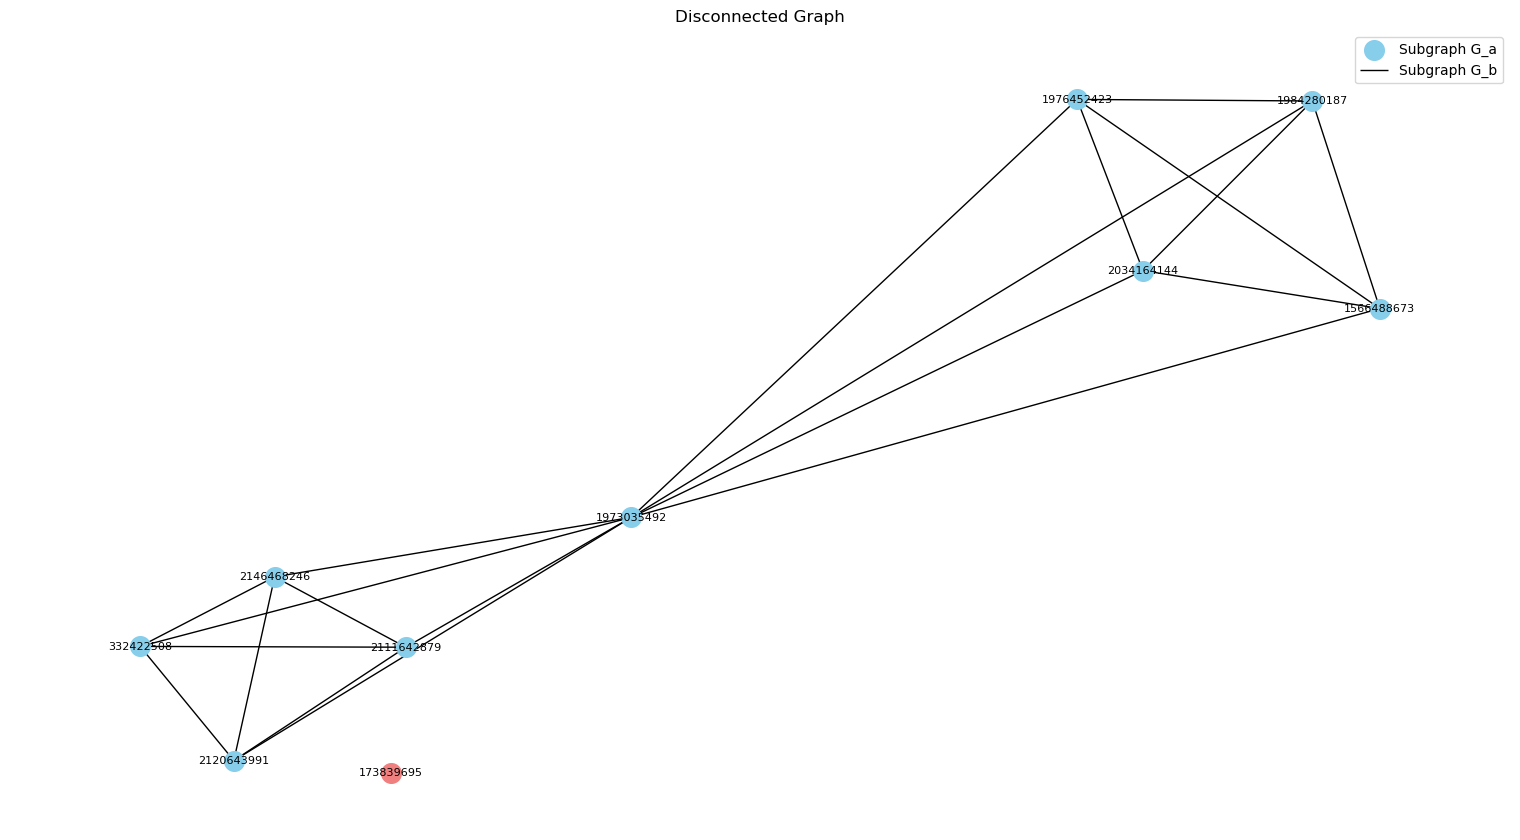

In [ ]:
# Plot the two disconnected graph and the original graph
visualize_disconnected_graph(subgraph, G_a, G_b, num_edges_in_min_cut)

### Visualization 5 - Visualize the communities
We anticipate seeing the Functionality 5 report in Visualization 5. To be more specific, we expect you to have the following report format:

 - Print the number of links that should be removed to have the communities
 - A table depicting the communities and the papers that belong to each community
 - Plot the original graph 
 - Plot the graph showing the communities in the network 
 - Plot the final graph and identify the community/communities of Paper_1 and Paper_2

---

The steps followed for this visualization are outlined in the `print_community_table` and `plot_communities` function located in the `functions.py` file of the repository, which has comprehensive code comments.

Community	Papers
------------------------------
Community 1:	2041404167, 2161969291, 1971784203, 2163605009, 2162915993, 2159080219, 2119821739, 2156909104, 1501500081, 2121947440, 2153635508, 2296616510, 2124386111, 2151103935, 2031489346, 2117539524, 2076063813, 2147152072, 2102605133, 2618530766, 47957325, 2168356304, 1956559956, 2163922914, 2108598243, 2150341604, 1880262756, 2072128103, 1639032689, 2147800946, 2912934387, 2165949425, 1660562555, 1986931325
Community 2:	2100408980, 1987198869, 1791587663
Community 3:	2125055259
Community 4:	2156186849, 1996360405, 1655990431
Community 5:	2118428193
Community 6:	2096525273, 2141885858
Community 7:	2164598857, 1988790447
Community 8:	2066636486
Community 9:	2130509920
Community 10:	2148251644, 2157457404


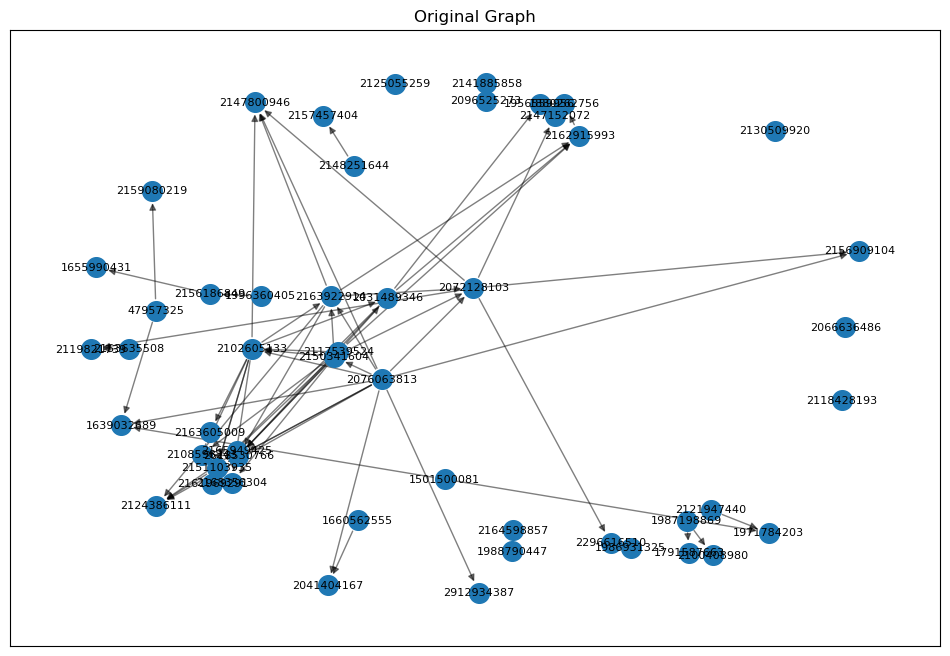

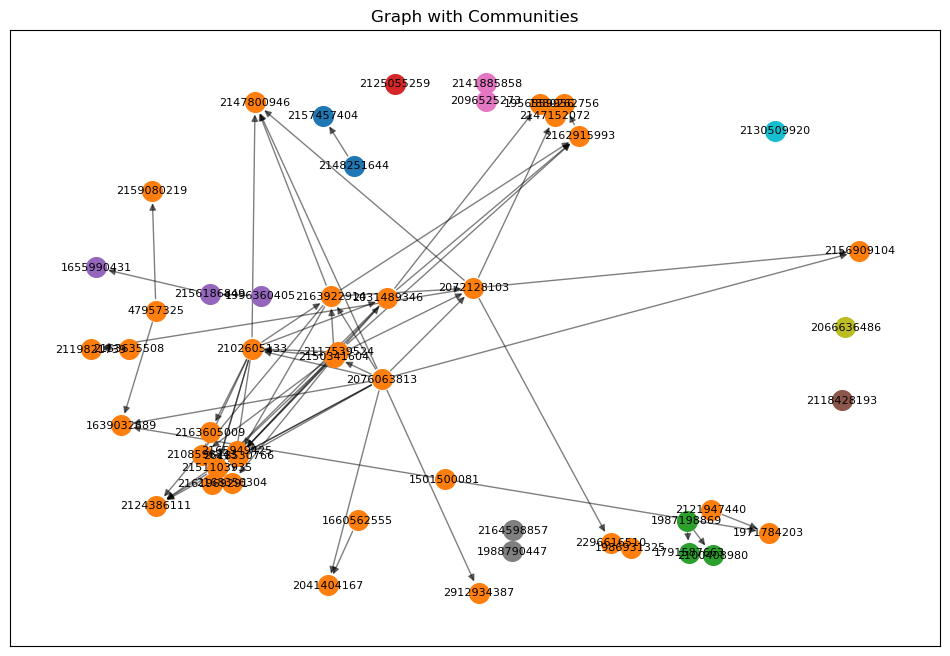

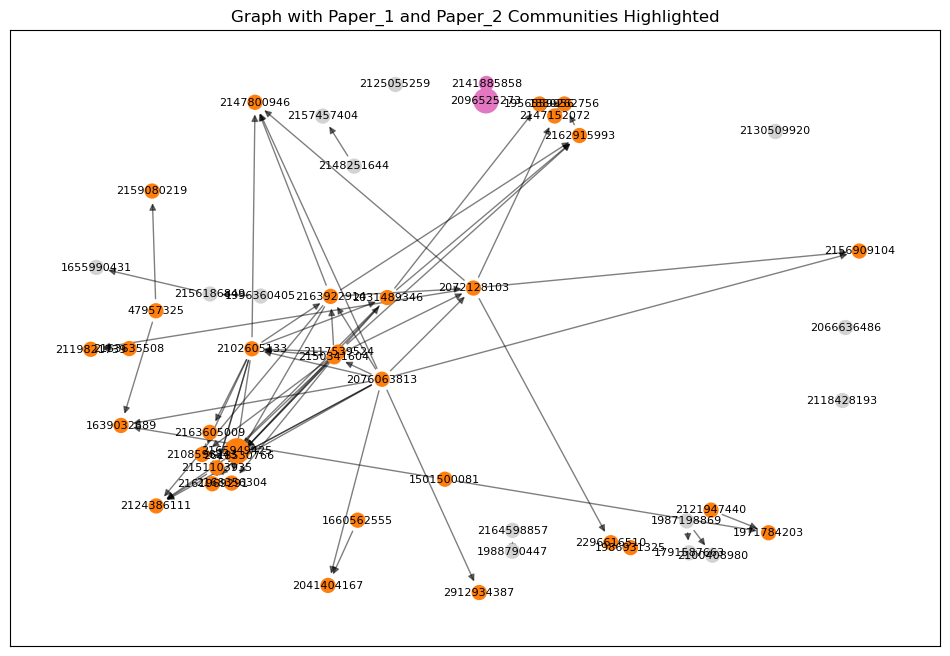

In [ ]:
# Print a table showing  communities and the papers that belong to each community
print_community_table(extracted_communities)

# Plot the original graph, the graph showing the communities, and the final graph with Paper_1 and Paper_2 communities highlighted
plot_communities(subgraph, extracted_communities, paper_1, paper_2)

### Control System

In [ ]:
# Append the path to the directory containing the functions module so that Python can locate the module regardless of the current working directory
import os
# Please change this address accordingly
os.sys.path.append('/content/drive/MyDrive/ADM/ADM_HW5')

# Import the control_system function
from functions import control_system

We designed a control system using IPyWidgets library in a way that provides maximum flexibility for user inquiries. Below, we ran 5 queries for the 5 visualization task. We should note that this system works fine for visualizations 1, 2, and 5; however, since the number of graph nodes is large, we were not able to interact with the corresponding dropdown widgets (which include sorted values of authors/papers ID). We also tried to limit the number of nodes (e.g. decreasing the graphs' dimensionality) by selecting the top 500 papers. This caused the control system to work nicely and smoothly. However, it was very hard to find a meaningful pair of nodes for the visualization of the shortest-ordered route and disconnected graph.
This is the reason why we first, provided our visualization functions along with their sample queries, and here at the end of the visualization section, provided our control system function.
### Note: For further details on the implementation of the control system,please refer to the the corresponding docstrings and comments in the functions.py file.

Dropdown(description='Graph Type', index=1, layout=Layout(width='30%'), options=('Collaboration_G', 'Citation_…

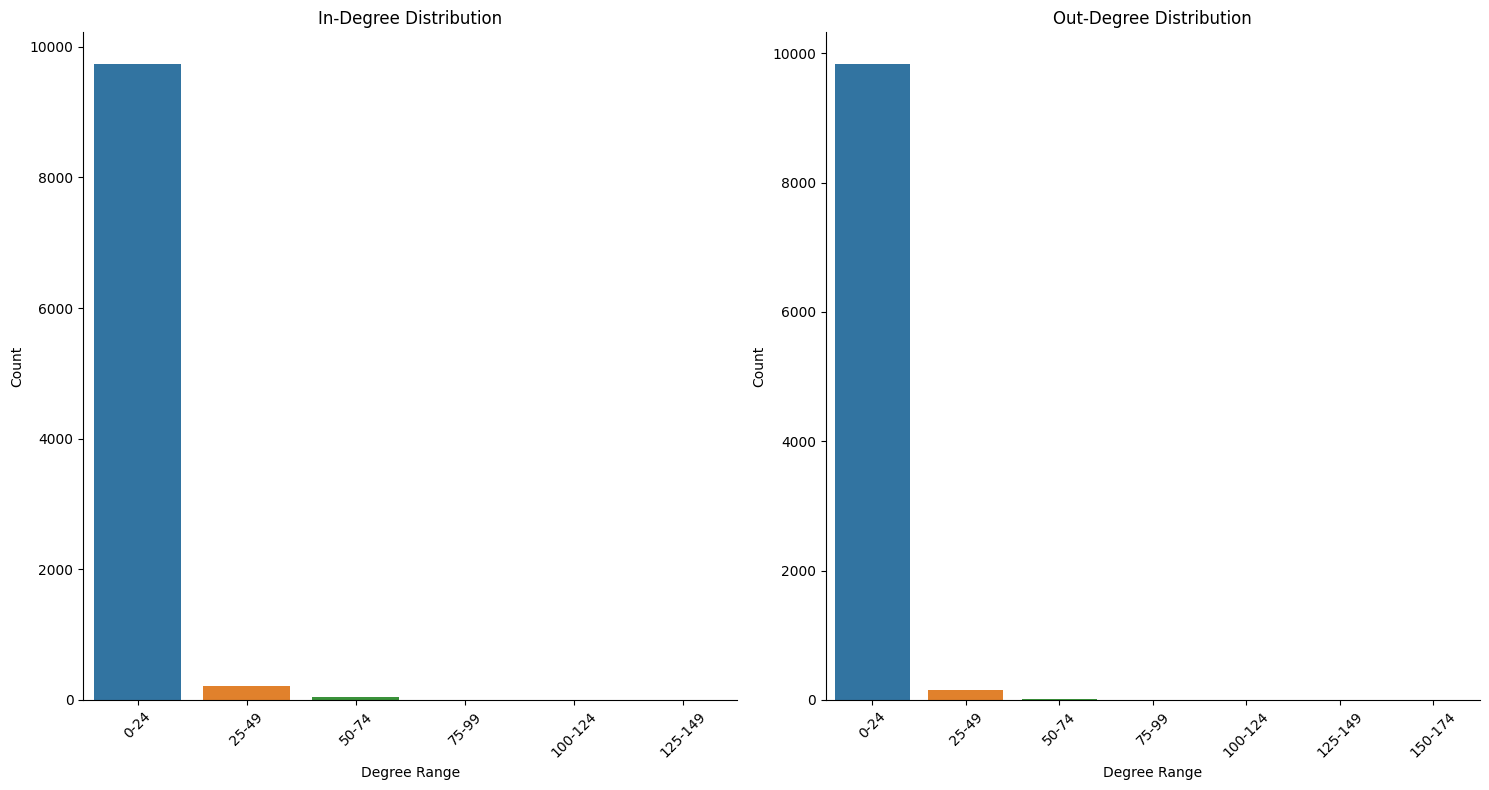

+-----------------------------------------------------------------------------------------+
|                                        Citation_G                                       |
+-----------------+-----------------+-----------------------+------------+----------------+
| Number of Nodes | Number of Edges |     Graph Density     | Graph Type | Average Degree |
+-----------------+-----------------+-----------------------+------------+----------------+
|      10000      |      52253      | 0.0005225822582258226 |   sparse   |     5.2253     |
+-----------------+-----------------+-----------------------+------------+----------------+


,Graph Hubs
0,2041404167
1,1639032689
2,2912565176
3,2151103935
4,2911964244
...,...
1678,1827261456
1679,2005624335
1680,2157283388
1681,2295541535


In [ ]:
# Using control system for visualization 1
control_system(Citation_G, Collaboration_G)

In [ ]:
# Using control system for visualization 2
control_system(Citation_G, Collaboration_G)

Dropdown(description='Visualization', index=1, layout=Layout(width='40%'), options=('Graph_features', 'Nodes_c…

Dropdown(description='Graph Type', index=1, layout=Layout(width='30%'), options=('Collaboration_G', 'Citation_…

Dropdown(description='Papers ID', index=28, layout=Layout(width='20%'), options=(852874, 1699105, 2169610, 421…

+-----------------------------------------------------------------------------------------+
|                       Contribution of node 38739846 in Citation_G                       |
+----------+------------------------+----------+----------------------+-------------------+
|   Node   | Betweenness Centrality | PageRank | Closeness Centrality | Degree Centrality |
+----------+------------------------+----------+----------------------+-------------------+
| 38739846 |         0.0000         |  0.0001  |        0.0006        |       0.0013      |
+----------+------------------------+----------+----------------------+-------------------+


In [ ]:
# Using control system for visualization 3
control_system(Citation_G, Collaboration_G)

Dropdown(description='Visualization', index=2, layout=Layout(width='40%'), options=('Graph_features', 'Nodes_c…

Dropdown(description='Graph Type', layout=Layout(width='30%'), options=('Collaboration_G',), value='Collaborat…

Please select the initial node (author 1) and the end node (author 2), respectively:


In [ ]:
# Using control system for visualization 4
control_system(Citation_G, Collaboration_G)

Dropdown(description='Visualization', index=3, layout=Layout(width='40%'), options=('Graph_features', 'Nodes_c…

Dropdown(description='Graph Type', layout=Layout(width='30%'), options=('Collaboration_G', 'Citation_G'), valu…

Please select Author A (sub-graph G_a) and Author B (sub-graph G_b), respectively:


Dropdown(description='Visualization', index=4, layout=Layout(width='40%'), options=('Graph_features', 'Nodes_c…

Dropdown(description='Graph Type', index=1, layout=Layout(width='30%'), options=('Collaboration_G', 'Citation_…

Please select Paper 1 and Paper 2, respectively:


Community	Papers
------------------------------
Community 1:	2041404167, 2161969291, 1971784203, 2163605009, 2162915993, 2159080219, 2119821739, 2156909104, 1501500081, 2121947440, 2153635508, 2296616510, 2151103935, 2124386111, 2031489346, 2117539524, 2076063813, 2147152072, 2102605133, 2618530766, 47957325, 2168356304, 1956559956, 2163922914, 2108598243, 2150341604, 1880262756, 2072128103, 1639032689, 2147800946, 2912934387, 2165949425, 1660562555, 1986931325
Community 2:	2100408980, 1987198869, 1791587663
Community 3:	2125055259
Community 4:	2156186849, 1996360405, 1655990431
Community 5:	2118428193
Community 6:	2096525273, 2141885858
Community 7:	2164598857, 1988790447
Community 8:	2066636486
Community 9:	2130509920
Community 10:	2148251644, 2157457404


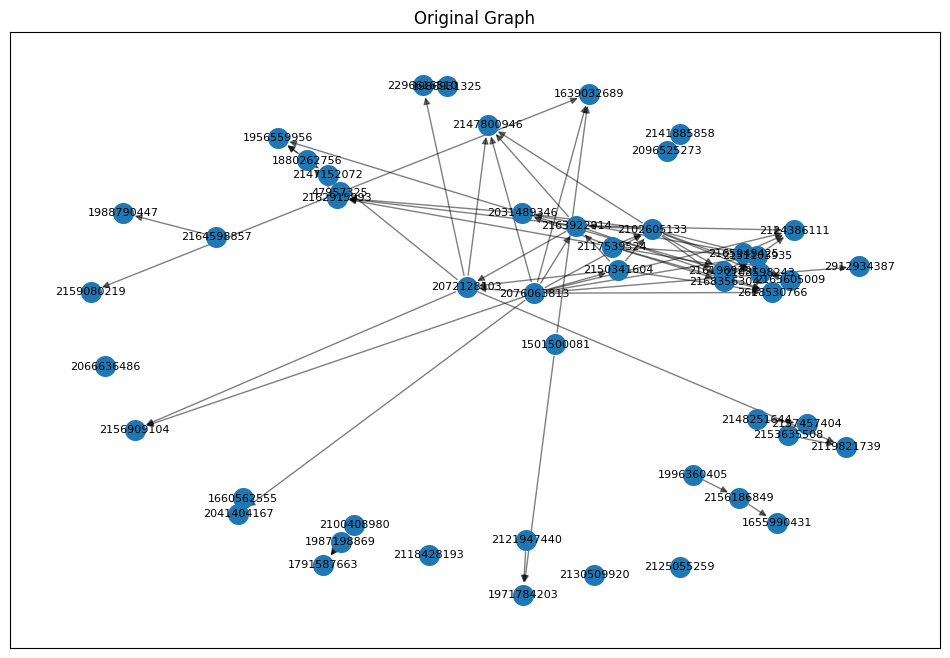

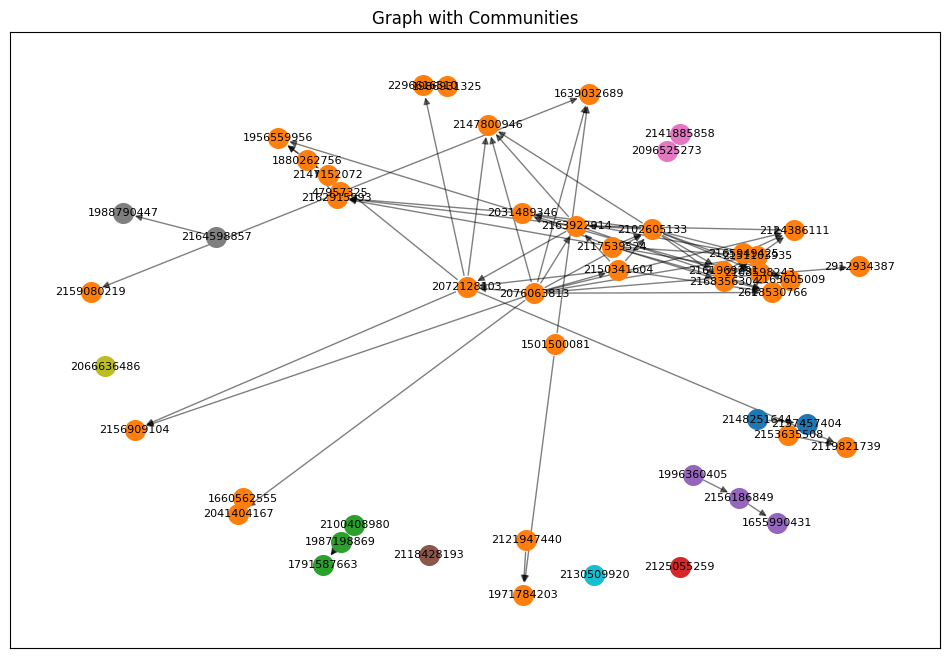

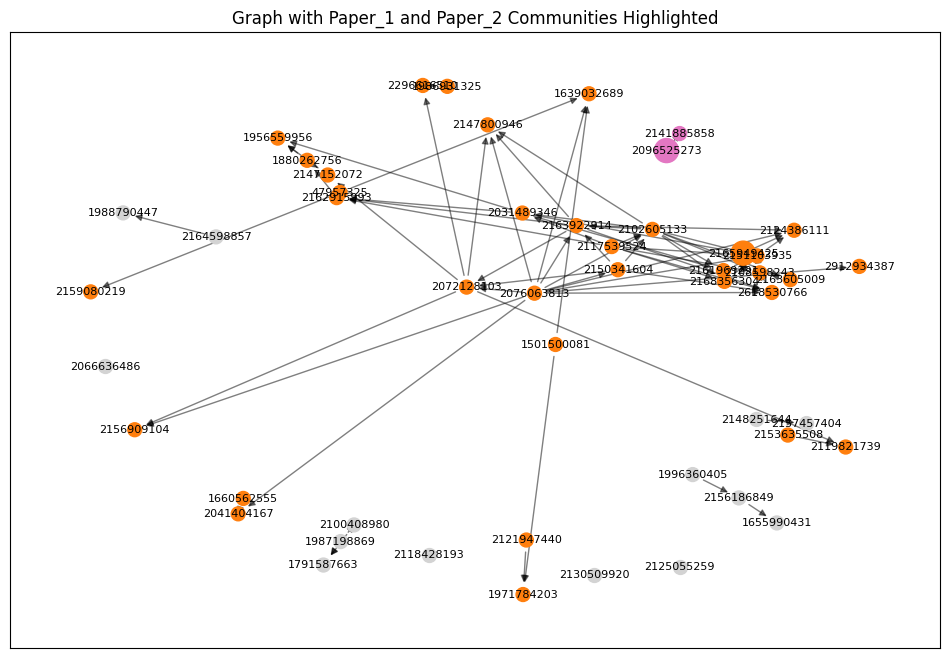

In [ ]:
# Using control system for visualization 5
control_system(Citation_G, Collaboration_G)

# 3. Bonus - PageRank on MapReduce 

__IMPORTANT:__ This is a bonus step, so it's <ins>not mandatory</ins>. You can get the maximum score without doing this. We will consider this, __only if__ the rest of the homework has been completed.

Working with big data has become increasingly important in the modern era as the volume and complexity of data generated grows. In this part, we ask you to __implement the PageRank algorithm using MapReduce paradigm__ to compute the <ins>importance of papers</ins> based on the citation relationship. 

Since a large dataset is required to fully understand the power of this paradigm, when creating the Citation graph, consider the __top 1,000,000 papers__ that have received the most citations; then, make the graph exclusively for those papers. 

__Hint:__ 
[Here](https://www.cs.utah.edu/~jeffp/teaching/cs5140-S15/cs5140/L24-MR+PR.pdf) are __two approaches__ to implement the PageRank algorithm using the MapReduce paradigm that you can use as a reference for your bonus part.

---

First, we need to create the graph, and we do it using the same code as in point 1, but this time extracting the top 1 million pages based on the number of citations identified by the `n_citation` column of the `json_to_csv` dataset.

In [2]:
# The flag variable, when set to True, create the necessary graph for this point 
# otherwise, if it has already been created, simply load it
Flag = False

if Flag:    
    # Import the converted dataset from Question 1
    papers_df = pd.read_csv("json_to_csv.csv")

    # Extract the top 1,000,000 papers that have received the most citations
    Ext_citations_df = papers_df.nlargest(1000000, columns='n_citation')

    # Create an Extended Citation Graph using the same approach as in Question 1
    # Initialize a directed unweighted graph
    Graph_bonus = nx.DiGraph()

    # Add nodes and edges to the graph
    for _, row in Ext_citations_df.iterrows():
        paper_id = row['id']
        paper_type = str(row['doc_type'])

        # Add source node with the year as an attribute
        Graph_bonus.add_node(paper_id, paper_year=int(row['year']))
        # Assign the paper type to the node if available
        if paper_type != 'nan':
            Graph_bonus.nodes()[paper_id]['paper_type'] = paper_type

    # Iterate again to add edges from each paper to its references
    for _, row in Ext_citations_df.iterrows():
        paper_id = row['id']
        references = str(row['references'])

        # Add edges from the source to each reference
        if references != 'nan':
            for reference in references.split(';'):
                # Check if the referenced node exists before adding the edge
                if Graph_bonus.has_node(int(reference)):
                    Graph_bonus.add_edge(paper_id, int(reference))
    
    # Save the Extended Citatio-Graph
    # we need only the edges  
    nx.write_edgelist(Graph_bonus, "Citation_Graph_bonus.edgelist", data=False)

else:
    # If we have already created the Extended-Citation-Graph we can simply loard it
    Graph = nx.read_edgelist("Citation_Graph_bonus.edgelist")

Since the `pagerank_map_reduce` function is the answer to the question, we decided to include it directly in the notebook rather than importing it from a support .py file.

In [3]:
def pagerank_map_reduce(graph, num_iterations=10, damping_factor=0.85):
    """
    Implements the PageRank algorithm using a MapReduce approach

    Argumnets of the function:
    graph (nx.DiGraph) -> A NetworkX graph
    num_iterations (int) -> Number of iterations for the PageRank algorithm
    damping_factor (float) -> Damping factor representing the probability of continuing the random walk

    Returns:
    scores (dict) -> A dictionary with nodes as keys and their PageRank scores as values
    """

    # Define the MAP function for the PageRank algorithm
    def map_function(node, score):
        # Extract the nodes linked to the current node
        outgoing_links = list(graph[node])
        # Check if the current node has outgoing links
        if outgoing_links:
            # Calculate the score for each outgoing link
            score_per_link = score / len(outgoing_links)
            # Iterate over each outgoing link
            for link in outgoing_links:
                # Emitting a pair (destination node, distributed score)
                yield link, score_per_link
        else:
            # For dangling nodes, emitting a special "DANGLING" pair
            # This ensures even distribution of PageRank score from nodes 
            # with outgoing links and proper handling of dangling nodes
            yield "DANGLING", score
    # Note: the use of 'yield' allows to emit each pair of (node,score) as soon 
    #       as it's computed without have to waite for all computations to complete
    #       this is more memory-efficient than collecting all pairs and the return them
   

    # Define the REDUCE function for the PageRank algorithm
    def reduce_function(mapped_scores):
        # Initialize a new dictionary for updated scores
        new_scores = {node: (1 - damping_factor) / len(graph) for node in graph}
        # The initial score assigned here prevents rank sinks and ensures that every node has a minimum rank
        # Initialize a variable to track the total score of dangling nodes
        dangling_score = 0

        # Iterate over each pair of (node, score) emitted by the map function
        for node, score in mapped_scores:
            # If the pair is for a dangling node
            if node == "DANGLING":
                # Adding the score to the total of dangling nodes
                dangling_score += score
            else:
                # Update the nodes score with the damping factor
                # The damping factor models the random surfer behavior and stabilizes 
                # the distribution of PageRank scores
                new_scores[node] += damping_factor * score
        
        # Calculate the portion of the score of the dangling nodes to distribute to each node
        distributed_dangling_score = dangling_score / len(graph)
        # Iterate over each node in the graph
        for node in graph:
            # Add the portion of the dangling nodes score to the nodes score
            # This redistribution handles the rank sink issue caused by dangling nodes.
            new_scores[node] += damping_factor * distributed_dangling_score
    
        # Return the calculated new scores
        return new_scores

    # Initialize the PageRank scores for each node in the graph
    # Since the sum of the scores across the entire graph should be 1 or a value close to it 
    # we set a uniform initial value for all nodes
    scores = {node: 1 / len(graph) for node in graph}

    # Execute the algorithm for a specified number of iterations
    # Each iteration update the PageRank scores moving closer to a stable distribution
    for _ in range(num_iterations):
        # Create a list to collect the results from the map function
        new_scores = []
        # Apply the map function to each node and score
        for node, score in scores.items():
            # Extending the new_scores list with results from the map function
            new_scores.extend(map_function(node, score))
        # Apply the reduce function to the new scores
        scores = reduce_function(new_scores)

    # Returning the final PageRank scores
    return scores


Now that we have the function, we want to verify the results compared to the PageRank algorithm in networkx, which we know will provide the correct results that we will use as a benchmark. 

In [4]:
# Calculate the scores with our algorithm
my_scores = pagerank_map_reduce(Graph)
# Calculate the PageRank scores with the networkx funtion as benchmark
nx_scores = nx.pagerank(Graph)

For the comparison, we have implemented two solutions: 

1. Calculate the **Mean Squared Error (MSE)** between the scores obtained through our solution and those from networkx (a low value indicates a very low overall margin of error and that the two solutions are close to each other). This verification has been automated using the function we wrote, called `mse`, whose documentation is included in the `functions.py` file in the directory.

In [5]:
# Calculate the MSE score between the two solutions
print(f'MSE score: {mse(my_scores, nx_scores)}')

MSE score: 1.5145857640921868e-13


2. Check one by one if the difference between the scores found with the two solutions for each node is less than or equal to a threshold epsilon, which we have set to a default value of $0.001$. This verification has been automated using the function we wrote, called `score_check`, whose documentation is included in the `functions.py` file in the directory.

In [6]:
print(f'Percentage of successful comparison: {score_check(my_scores, nx_scores)}')

Percentage of successful comparison: 99.99989829005236 %


In light of these checks, we can conclude that our algorithm has achieved the prefixed objective.

# 4. Command Line Question (CLQ)

In this question, you should use any command line tools that you know to answer the following questions using the **directed** and **unweighted** graph that you have previously created: **Citation graph**: 

1. Is there any node that acts as an important "connector" between the different parts of the graph?
2. How does the degree of citation vary among the graph nodes? 
3. What is the average length of the shortest path among nodes?

__Important note:__ You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable. Please run the script and include a __screenshot__ of the <ins>output</ins> in the notebook for evaluation.  

---

In order to make the results more concise for a terminal window (mainly for the table in Q2), we chose to implement the solutions on the **largest strongly connected component sub-graph** of the **Citation Graph** created in step 1. To extract this graph, we used the following Python code:


In [3]:
# Get all strongly connected components
strongly_connected_components = nx.strongly_connected_components(Citation_G)

# Find the largest strongly connected component
largest_component = max(strongly_connected_components, key=len)

# Create a subgraph from the largest component
citation_subgraph = Graph.subgraph(largest_component)

# Save the sub-graph for the bash file of the CLQ
# we just need the edges 
nx.write_edgelist(citation_subgraph, "citation_subgraph.edgelist", data=False)

The results of these queries are displayed in the screenshot below and double checked with Python, while the code used can be found in the `CommandLine.sh` file in the repository. The file contains comprehensive comments explaining its functionality. Of course, the file is executable, and the results are reproducible if the following steps are followed:

1. The `CommandLine.sh` file and the graph file `citation_subgraph.edgelist` need to be placed in the same folder;

2. You must navigate to the folder containing the two files using the terminal;

3. You need to enable the execution permissions for the file by running the following code $\to$ `chmod +x CommandLine.sh`

4. Finally, you can execute the file using the following command $\to$ `./CommandLine.sh`

<code style="background:red;color:black">**ATTENTION !**</code>

This bash script utilizes the `gnuplot` function which is not presente natively in macOS. So if you are using a Mac you need to install the gnuplot manually. We can do this with a packages manager for macOS like `Homebrew`.

To install **Homebrew** we can pasting and executing the following command into the terminal

- `/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"`

This command can also been found on this link $ \to $ `https://brew.sh/`

After installing Homebrew we can install **gnuplot** by pasting and executing the following command in the terminal
- `brew install gnuplot`

This function should already be natively supported by the Windows operating system so, on such devices, no additional measures are required beyond those already outlined in points 1-2-3-4.

---

Here are the answer the answeres of the Command Line query:

- **Q1) Is there any node that acts as an important "connector" between the different parts of the graph?**

    For this question, we could have implemented various centrality measures such as `Betweenness Centrality`, `Closeness Centrality`, or even `PageRank`. Generally, the choice of the metric to use would depend on the context. However, in this case, as we had to use only Linux commands, we chose `Degree Centrality` because it could be calculated without using Python. The **Degree Centrality** of a node $(v)$ is a centrality measure that evaluates the importance of a node based on the number of direct connections it has with other nodes within the graph, normalized by the maximum number of connections it could have. It is defined by the following formula:

    $$ DC (v) = \frac{deg(v)}{n-1}$$

    where $n$ is the total number of node in the graph. A higher score indicates greater centrality in the graph.

    Using a short Python code, we know that the results we want to obtain with a bash script is the follows:

In [13]:
# Calculate the degree centrality using the networkx function
degree_centrality = nx.degree_centrality(citation_subgraph)

# Sort the results in descending order of centrality degree
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Create a Pandas DataFrame for the top 6 nodes with the highest centrality
top_5_nodes = sorted_degree_centrality[:6]
pd.DataFrame(top_5_nodes, columns=["Node", "Degree Centrality"])


,Node,Degree Centrality
0,2102605133,0.527273
1,2618530766,0.527273
2,2179352600,0.418182
3,2117539524,0.309091
4,1677182931,0.290909
5,1686810756,0.290909


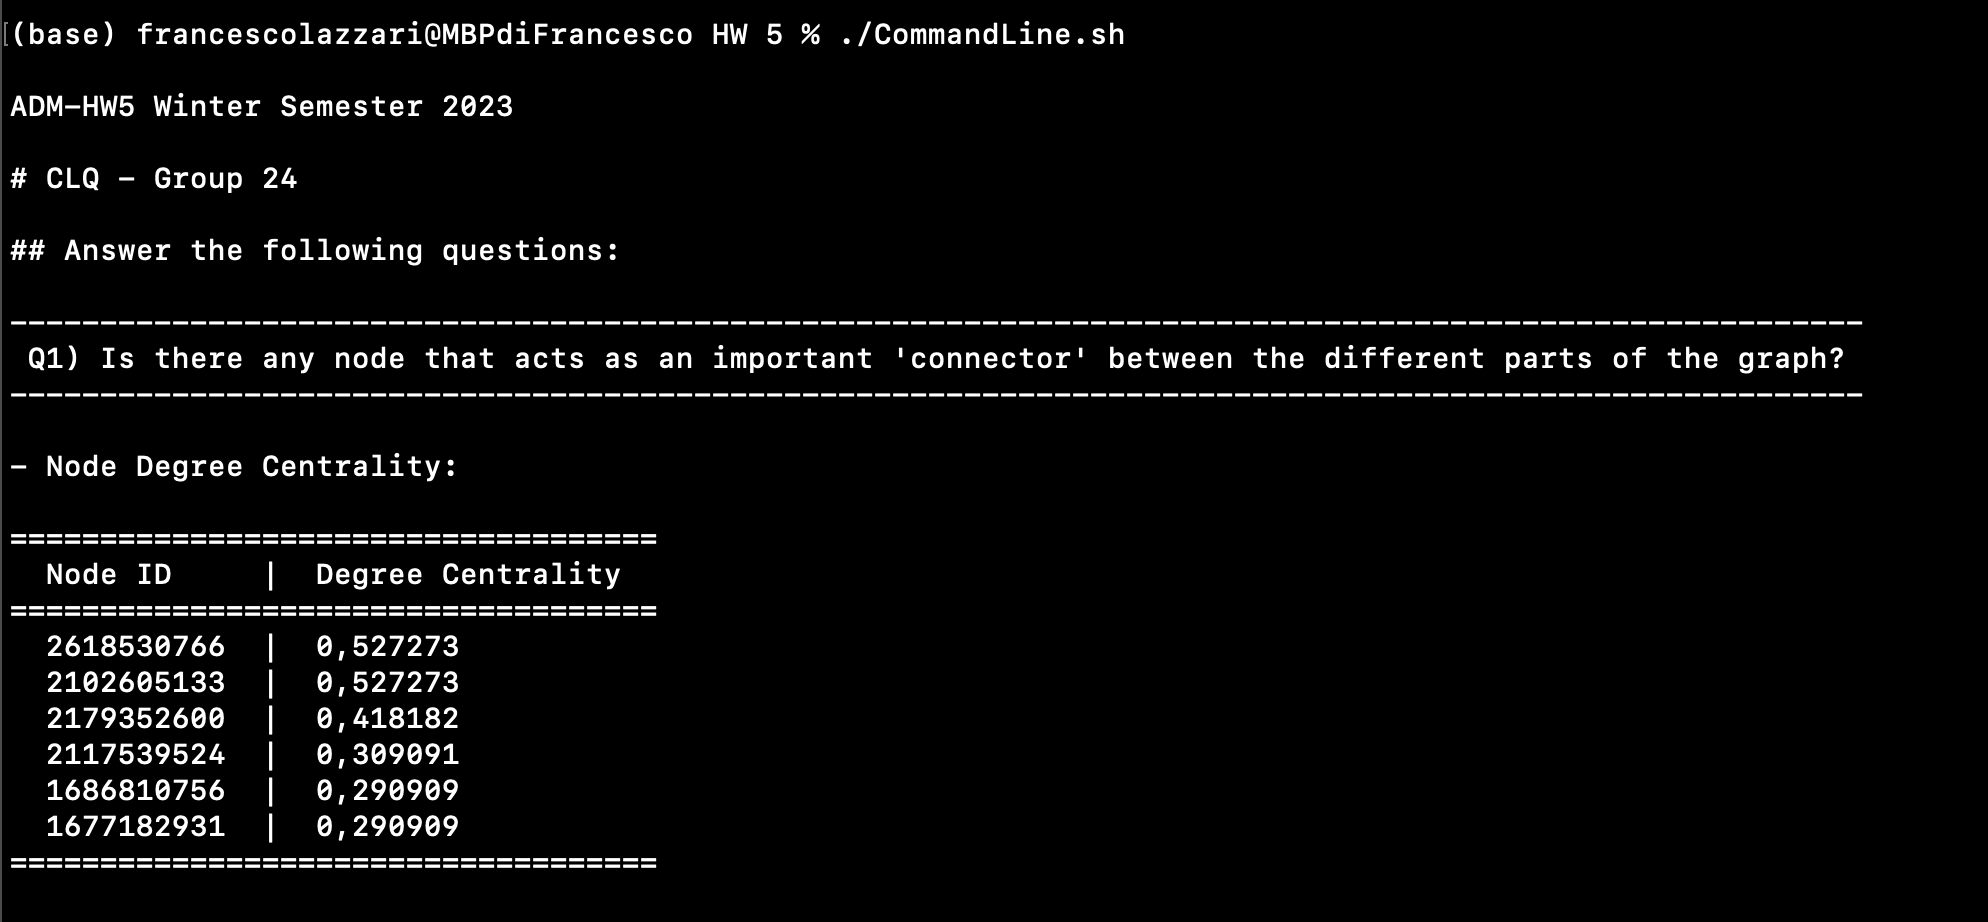

From the comparison, we can conclude that the results are essentially the same since the differences in ordering between the top two and bottom two results are negligible due to the same scores of those nodes. Therefore, we can conclude that nodes `2102605133` and `2618530766` are indeed important connectors in the graph, both having a degree centrality score of $\approx 0.5$. This score indicates that about half of the nodes in the graph are connected to these two nodes.

- **Q2) How does the degree of citation vary among the graph nodes?**

    For this question, in order to observe the degree variation within the graph, we decided to calculate the number of nodes for each degree value. Naturally, since this is a directed graph, we made a distinction between in-degree and out-degree. In this case as well, we initially verified the result with Python using the following code:


In [16]:
# Calculate the in-degree for each node
in_degrees = dict(citation_subgraph.in_degree())

# Count the frequency of each in-degree
in_degree_counts = Counter(in_degrees.values())

# Create a Pandas DataFrame for for the frequency table of the In-Degree Count sorted in ascending order of number of degree
pd.DataFrame(list(in_degree_counts.items()), columns=['In-Degree', 'Number of Nodes']).sort_values(by='In-Degree')

,In-Degree,Number of Nodes
0,1,17
3,2,9
5,3,9
7,4,5
2,5,2
4,6,4
8,7,4
6,9,2
1,11,2
9,27,2


In [10]:
# Calculate the Out-degree for each node
out_degrees = dict(citation_subgraph.out_degree())

# Count the frequency of each Out-degree
out_degree_counts = Counter(out_degrees.values())

# Create a Pandas DataFrame for for the frequency table of the Out-Degree Count sorted in ascending order of number of degree
pd.DataFrame(list(out_degree_counts.items()), columns=['Out-Degree', 'Number of Nodes']).sort_values(by='Out-Degree')

,Out-Degree,Number of Nodes
2,1,15
1,2,7
0,3,10
6,4,6
9,5,2
5,6,5
11,7,1
8,8,3
12,9,1
7,10,1


Also in this case, our bash script returns the same results from which we can observe that in this subgraph, most of the nodes tend to have a relatively low degree number.

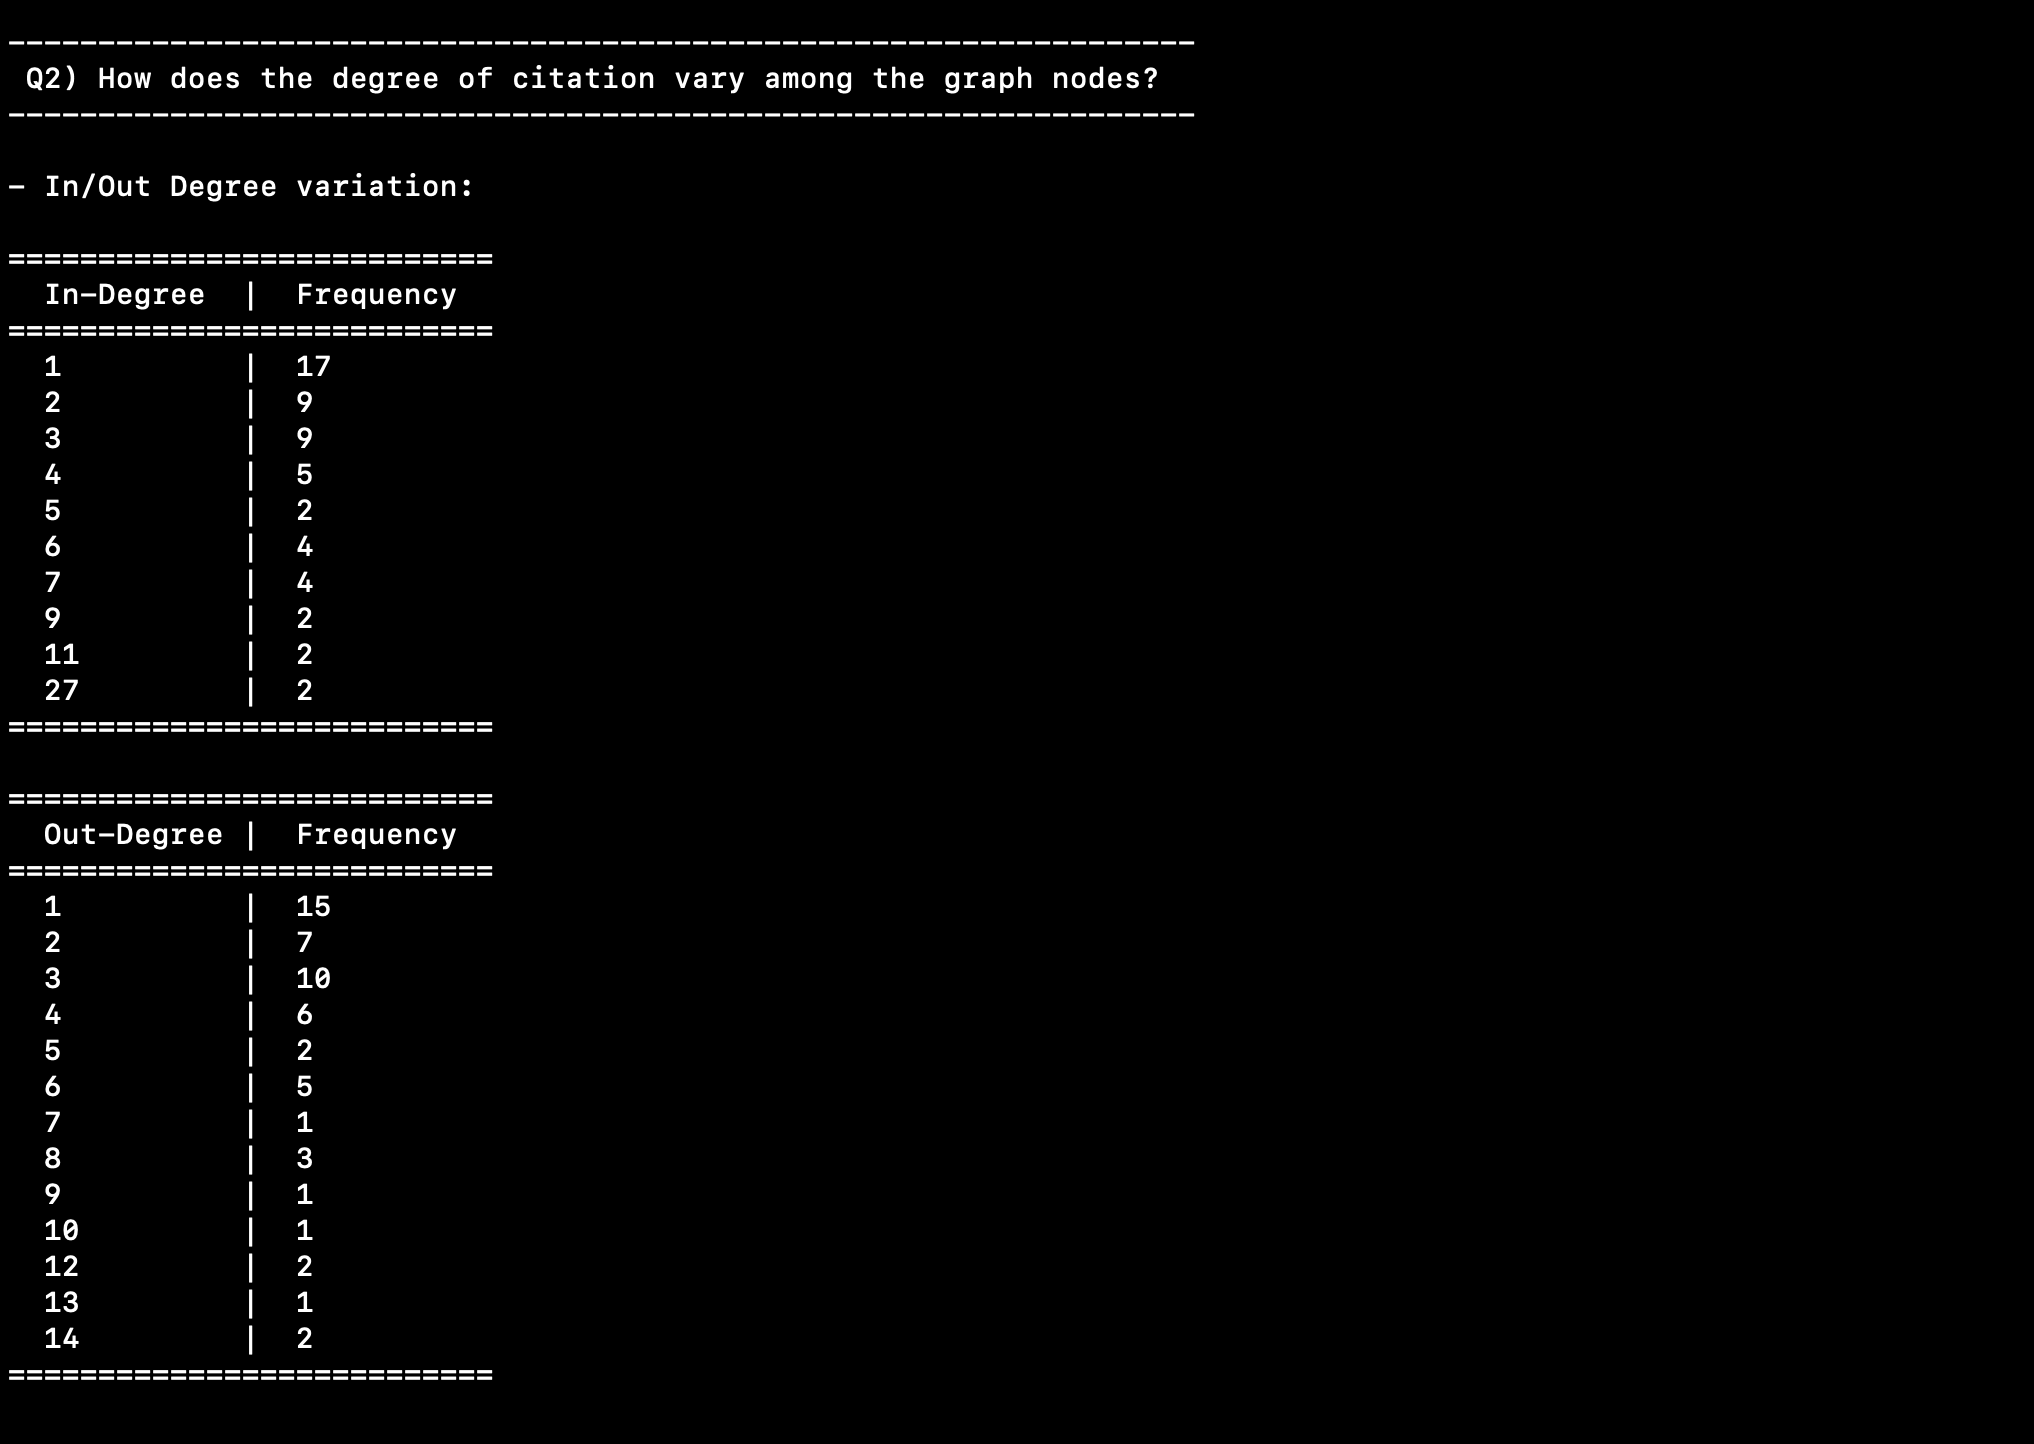

In order to visually observe these variations, we have created specific histograms using only Linux commands through the `gnuplot` function.

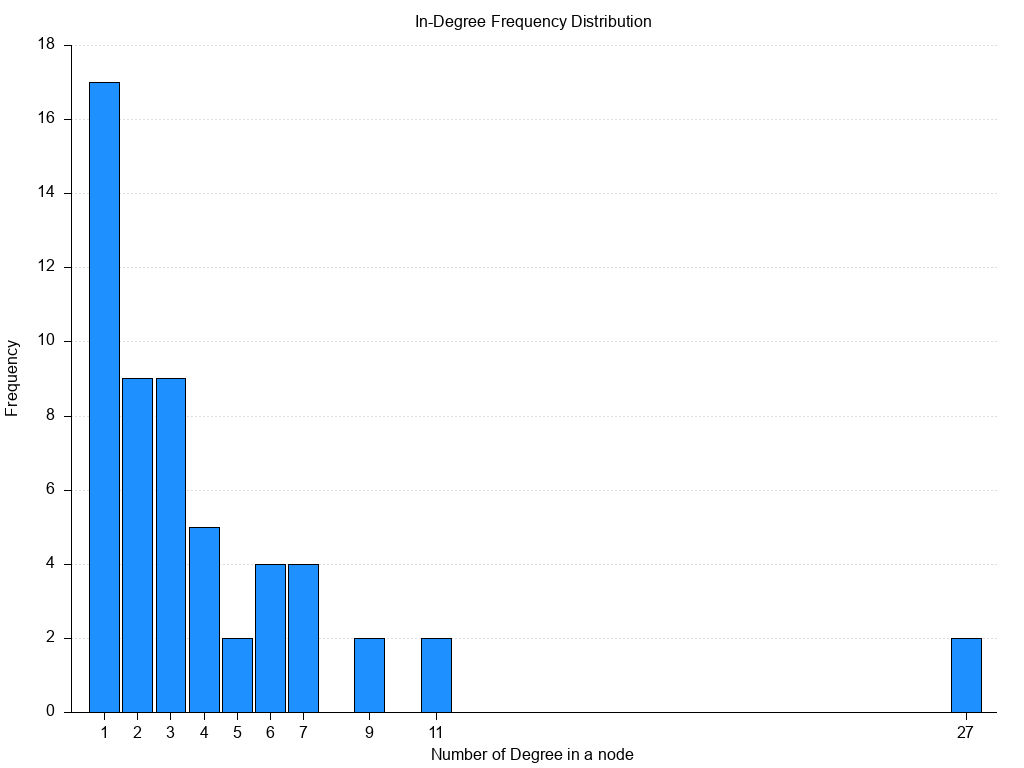
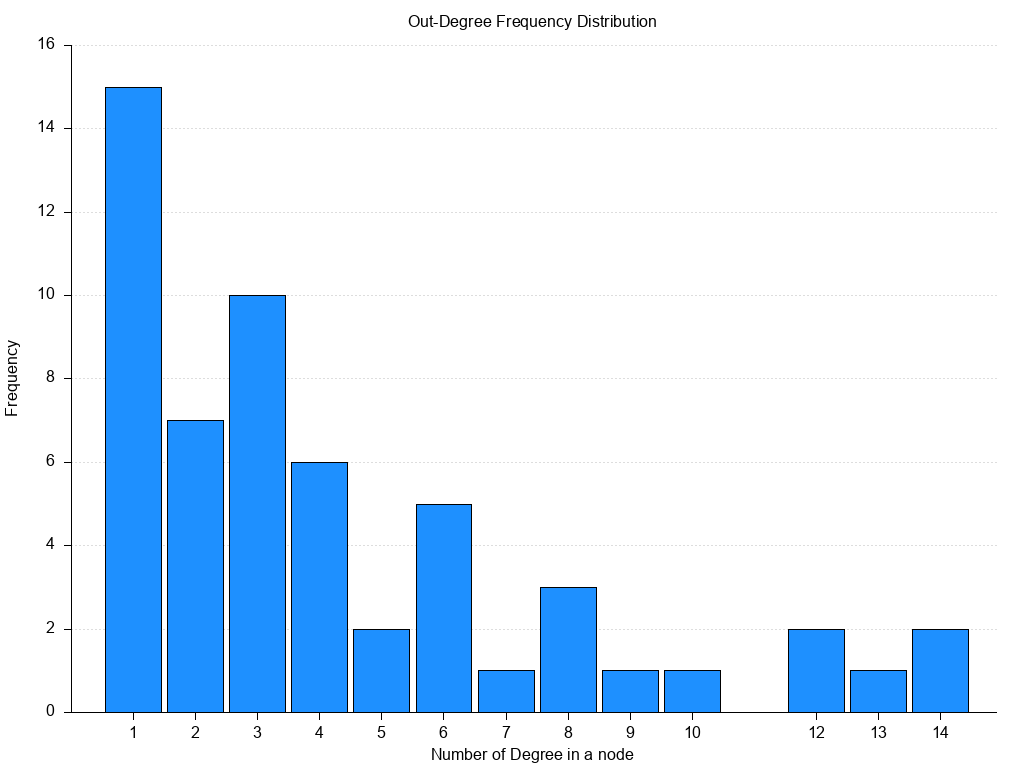

- **Q3) What is the average length of the shortest path among nodes?**

    For this question, due to the high computational complexity of calculating the shortest path for every node exclusively through Linux commands, we had to resort to using Python and the specific function of **networkx**, `average_shortest_path_length`. We know that this solution does not conform to the constraints given by the assignment. However, we believe that this was the only possible solution for us, since we are not enough skilled in bash programming to implement such algorithm. Obviously, we also know that we could have calculated the list of shortest path lengths with Python and then computed the average using bash commands. However, since the difficulty of the question was precisely that calculation, we considered the two approaches to be substantially equivalent, as applying the average is a very easy computation.

    Since the solution already involves Python, we have directly attached the bash script's response

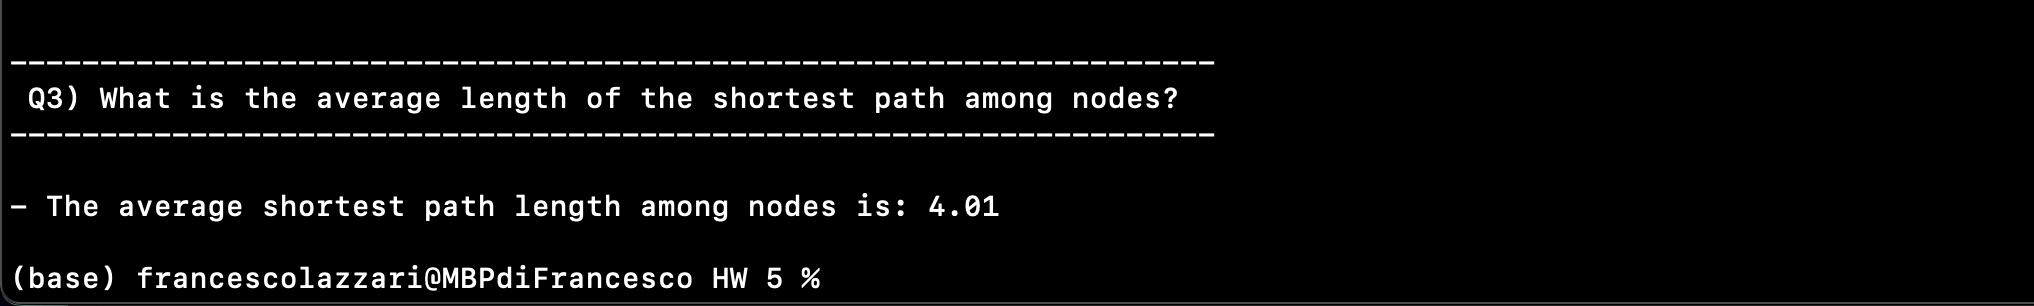

# 5. Algorithmic Question

---

### Part A

A sports club hires you to create a team for the National Sports Championship. Every Italian Region sends its best $M$ athletes to compete in an intense 2-day sports event, and Rome is no exception!

The trainers of Team Rome need to carefully choose the best $M$ athletes from a pool of $N$ candidates. Each athlete is uniquely identified by a number from 1 to $N$ and possesses a set of $S$ sports skills. Each skill is represented by a 3-character string with only uppercase letters and a non-negative integer indicating the athlete's proficiency in that skill (always greater than 0).

The trainers have extensively studied the competition format and established an optimal set of (possibly repeated) skills the team should possess to ensure the best possible performance. Each of the ten selected athletes will be assigned one of these skills as their role within the team.

The team's overall score is the sum of the skill scores of its members in the roles they have been assigned. Other skills of each athlete do not contribute to the team's score.

Your task is to determine the maximum possible global score for Team Rome, given the list of candidates.


__Input__
The input consists of $2 + N(S + 1)$ lines:
- Line 1: the numbers $N, M,$ and $S$, separated by a space.
- Line 2: the optimal set of skills required by the trainers, as a list of $M$ space-separated skill names.
- Lines 3, . . . , $N(S + 1) + 2$: every group of $S + 1$ lines is formatted as follows:
  - Line 1: the unique id of the athlete.
  - Lines 2, . . . , $S + 1$: one skill name and the corresponding skill score, separated by a space.

__Output__
Print the maximum global score that can be achieved with the available athletes.

__Input 1__
```
14 10 1 # N, M, S
SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK #set of skills
1
BSK 98
2
ATH 14
3
HCK 82
4
HCK 9
5
FTB 90
6
ATH 52
7
HCK 95
8
TEN 85
9
RGB 46
10
SWM 16
11
VOL 32
12
SOC 41
13
SWM 59
14
SWM 34
```
__Output 1__
```
370
```
---
__Input 2__
```
14 10 2 # N, M, S
SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK #set of skills
1
BSK 98
HCK 12
2
ATH 14
VOL 1
3
HCK 82
ATH 30
4
HCK 9
SWM 27
5
FTB 90
HCK 50
6
ATH 52
RGB 80
7
HCK 95
SWM 11
8
TEN 85
RGB 7
9
RGB 46
SWM 30
10
SWM 16
BSK 12
11
VOL 32
HCK 40
12
SOC 41
FTB 12
13
SWM 59
TEN 82
14
SWM 34
VOL 20
```
__Output 2__
```
399
```
__Your job__:
1. Implement an algorithm to solve the described mentioned problem. 

2. What is the __time complexity__ (the Big O notation) of your solution? Please provide a <ins>detailed explanation</ins> of how you calculated the time complexity.

3. Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Compare your answer to theirs. If the <ins>two differ</ins>, which one is right? (why?)
   
4. If you algorithm has exponential time complexity, can you provide a __polynomial-time version__? 

5. If $S=1$, how does the __time complexity__ of an optimal algorithm to solve this problem change?

---

### **1. Implement an algorithm to solve the described mentioned problem.**

To solve this problem, we need to assign M players, each possessing S skills, from a pool of N players to a specific sport that meets a certain set of required skills. The objective is to maximize the score. 

We come up with the idea that brute-force will be our baseline solution fot this problem. However, we will optimize the brute-force solution to make it more efficient.

**Baseline solution:** 

Before we start, we will parse the input and store the data in a matrix format. There will be two matrices, one for athletes id and their skills, and the other their corresponding scores. Two matrices will be N x M size.
They will look like this:
* **Athletes Matrix:**

|SWM|VOL|ATH|VOL|VOL|BSK|HCK|BSK|SWM|BSK|
|---|---|---|---|---|---|---|---|---|---|
|10.|11.|2. |11.|11.|1. |3. |1. |10.|1. |
|13.|0. |6. |0. |0. |0. |4. |0. |13.|0. |
|14.|0. |0. |0. |0. |0. |7. |0. |14.|0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |

* **Scores Matrix:**

|SWM|VOL|ATH|VOL|VOL|BSK|HCK|BSK|SWM|BSK|
|---|---|---|---|---|---|---|---|---|---|
|16.|32.|14.|32.|32.|98.|82.|98.|16.|98.|
|59.|0. |52.|0. |0. |0. |9. |0. |59.|0. |
|34.|0. |0. |0. |0. |0. |95.|0. |34.|0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |
|0. |0. |0. |0. |0. |0. |0. |0. |0. |0. |

Athletes Matrix will be used as an input to iterate and select various combinations of players. Scores Matrix will be used to calculate the score of each combination.

**First Optimization:**       
*  We will create all permutations of M players from N players, and for each permutation we will calculate their score.  This way of solving problem includes all possible permutation will bee too slow, as it will cosider many zeros. We need only iterate through some part of a matrix which contains only non-zero values and second encounter of zero value will be the end of the iteration. In this way we will reduce the number of iterations and speed up the algorithm.

**Second Optimization:**

* First Selection: As we going to iterate through the matrix, we will select the first player in first column, and then we will select the second player in second column, and so on. We will also ensure that one player is not selected twice. 
So fisrt selection of the players will be like this:

**10->11->2->0->0->1->3->0->13->0**

* Iterative Process: We persist with this method, navigating through the columns of necessary skills and picking suitable team athlete id. This incremental procedure continues until we have assembled a full team.

* Optimizing with Backtracking: When assembling a complete team, we don't halt; instead, we backtrack. After we have collected the full team of 10 players, we go back to the 9th column, considering different players who could fit there. Then again we go back to the 8th column and iterate through athletes and so on. This method lets us reevaluate our choices, seeking different combinations that might raise the overall score.

* Thoroughly Exploring Combinations: We iteratively repeat this backtrack process for every column(required skill), going through every potential player combination.

* Incorporating Dynamic Programming: Throughout this process, we employ dynamic programming to save and reuse prior calculation results. This tactic prevents redundant computations, optimizing the process by computing each unique team setup only once.

* Previous Optimization: This backtracking algorithm also don't iterate through whole matrix and consider only first encountered zero in the column. So it will stop the recursion function when it encounters the second zero and go back to the previous column. This will speed up the algorithm.

* Selecting the Best Team: Each selection of players will have a score. And this max_score will be updated each time when a team of 10 athletes is assembled and it greater than previous score. 



In [ ]:
input_data_1 = """
14 10 1
SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK
1
BSK 98
2
ATH 14
3
HCK 82
4
HCK 9
5
FTB 90
6
ATH 52
7
HCK 95
8
TEN 85
9
RGB 46
10
SWM 16
11
VOL 32
12
SOC 41
13
SWM 59
14
SWM 34
"""

input_data_2 = """
14 10 2 
SWM VOL ATH VOL VOL BSK HCK BSK SWM BSK
1
BSK 98
HCK 12
2
ATH 14
VOL 1
3
HCK 82
ATH 30
4
HCK 9
SWM 27
5
FTB 90
HCK 50
6
ATH 52
RGB 80
7
HCK 95
SWM 11
8
TEN 85
RGB 7
9
RGB 46
SWM 30
10
SWM 16
BSK 12
11
VOL 32
HCK 40
12
SOC 41
FTB 12
13
SWM 59
TEN 82
14
SWM 34
VOL 20
"""

The `create_matrix` function takes a string of input data and processes it to create two matrices: `ath_matrix` and `scores_matrix`.

* After parsing all the athletes' data, the function initializes two matrices: `ath_matrix` and `scores_matrix`. Both matrices have dimensions `N x M` (number of athletes by number of skills).

* The function then fills these matrices. For each required skill, it finds the athletes who have that skill and fills the corresponding column in `ath_matrix` with the athletes' IDs and the corresponding column in `scores_matrix` with the athletes' scores for that skill.


In [ ]:
def create_matrix(input_data: str) -> Tuple[np.ndarray, np.ndarray]:
    #split the input data into lines
    input_lines = input_data.strip().split('\n')
    
    #parse the first line to get the number of athletes (N), skills (M), and skill sets (S)
    N, M, S = [int(value) for value in input_lines[0].split()]
    
    #parse the second line to get the required skills
    required_skills = input_lines[1].split()
    
    #initialize a dictionary to store the athletes' data
    athletes_data: Dict[int, Dict[str, int]] = {}
    line_index = 2
    
    #parse the athletes' data
    for _ in range(N):
        athlete_id = int(input_lines[line_index])
        athlete_skills: Dict[str, int] = {}
        for _ in range(S):
            line_index += 1
            skill_name, skill_score = input_lines[line_index].split()
            athlete_skills[skill_name] = int(skill_score)
        athletes_data[athlete_id] = athlete_skills
        line_index += 1

    #initialize the athlete and score matrices
    ath_matrix = np.zeros((N, M))
    scores_matrix = np.zeros((N, M))

    #fill the matrices with the athletes' IDs and scores
    for i, skill in enumerate(required_skills):
        athlete_ids_with_skill = [athlete_id for athlete_id, athlete_skills in athletes_data.items() if skill in athlete_skills]
        for j, athlete_id in enumerate(athlete_ids_with_skill):
            if j < N:
                ath_matrix[j][i] = athlete_id
                scores_matrix[j][i] = athletes_data[athlete_id][skill]

    #return the matrices
    return ath_matrix, scores_matrix

Description of the `calculate_team_score`, `backtrack`, and `find_best_team_score` functions:

* The function `calculate_team_score` is defined, which takes a list of selected row indices and a scores matrix as input and returns an integer. This function calculates the total score of a team of athletes.

* The function `backtrack` is defined, which takes a matrix of athlete IDs, a list of currently selected athlete IDs, a list of selected row indices, a result list, a column index, a scores matrix, and a list containing the best score found so far as input. This function uses backtracking to find the best team of athletes.

* The function `find_best_team_score` is defined, which takes an athlete matrix and a scores matrix as input and returns an integer. This function finds the best team score by calling the `backtrack` function and then returns this score.

* In the `calculate_team_score` function, a variable `team_score` is initialized to 0. Then, for each selected row index, the corresponding score is added to `team_score`. Finally, `team_score` is returned.

* In the `backtrack` function, if the end of the matrix has been reached or 10 athletes have been selected, the team score is calculated and compared to the best score found so far. If the team score is better, the best score is updated. Then, the function returns.

* If the end of the matrix has not been reached and less than 10 athletes have been selected, the function iterates over the athletes in the current column. If an athlete ID is 0 or the athlete has already been selected, the function skips to the next athlete. Otherwise, the athlete is selected and the `backtrack` function is recursively called for the next column. After the recursive call, the last selected athlete is removed from the current selection.

* In the `find_best_team_score` function, the athlete matrix and scores matrix are converted to integer type. Then, the `backtrack` function is called to find the best team score, which is then returned.

In [ ]:
def calculate_team_score(selected_row_indices: List[int], scores_matrix: np.ndarray) -> int:
    #initialize the team score
    team_score = 0
    #add the score of each selected athlete to the team score
    for col, row_index in enumerate(selected_row_indices):
        team_score += scores_matrix[row_index][col]
    return team_score

def backtrack(matrix: np.ndarray, current_selection: List[int], selected_row_indices: List[int], result: List[int], col_index: int, scores_matrix: np.ndarray, best_score: List[int]) -> None:
    #if we have selected 10 athletes, calculate the team score
    if col_index == len(matrix[0]) or len(current_selection) == 10:
        team_score = calculate_team_score(selected_row_indices, scores_matrix)
        #if the team score is better than the previous best score, we will update the best score
        if team_score > best_score[0]:
            best_score[0] = team_score
        return
    
    zr_counter = 0

    #iterate over the athletes in the current column
    for i, athlete_id in enumerate(matrix[:, col_index]):
        #if the athlete id is 0, increment the zero counter and if we have encountered two zeros, return
        if athlete_id == 0:
            zr_counter += 1
            if zr_counter == 2:
                return
        #if the athlete has already been selected, skip to the next athlete
        elif athlete_id in current_selection:
            continue
        #select the athlete and add their id to the current selection
        current_selection.append(athlete_id)
        #add the row index to the list of selected row indices
        selected_row_indices.append(i)
        
        #recursively call the backtrack function for the next column
        backtrack(matrix, current_selection, selected_row_indices, result, col_index + 1, scores_matrix, best_score)
        #remove the last selected athlete and row index from the current selection and selected row indices
        current_selection.pop()
        selected_row_indices.pop() 

def find_best_team_score(athlete_matrix: np.ndarray, scores_matrix: np.ndarray) -> int:
    #convert the matrices to integer type
    athlete_matrix = athlete_matrix.astype(int)
    scores_matrix = scores_matrix.astype(int)

    #initialize the best score to 0
    best_score = [0]
    
    #call the backtrack function to find the best team score
    backtrack(athlete_matrix, [], [], [], 0, scores_matrix, best_score)
    
    #return the best team score
    return best_score[0]

In [ ]:
start = timer()
#using the above functions to find the best team score
ath_matrix_1, scr_matrix_1 = create_matrix(input_data_1)
best_team_score_1 = find_best_team_score(ath_matrix_1, scr_matrix_1)
print("Best team score:", best_team_score_1)
end = timer()
print(end - start)

Best team score: 370
0.009814000004553236


In [ ]:
start = timer()
ath_matrix_2, scr_matrix_2 = create_matrix(input_data_2)
best_team_score_2 = find_best_team_score(ath_matrix_2, scr_matrix_2)
print("Best team score:", best_team_score_2)
end = timer()
print(end - start)

Best team score: 399
0.4463735409954097


---

### **2. What is the time complexity (the Big O notation) of your solution? Please provide a detailed explanation of how you calculated the time complexity.**

The `create_matrix` function has a time complexity that is primarily determined by the nested loops that iterate over the athletes and their skills. 

1. The first loop iterates over the number of athletes `N`. Inside this loop, there is another loop that iterates over the number of skills `S` each athlete has. This results in a time complexity of `O(N*S)` for this part of the function.

2. The second major loop iterates over the required skills `M`. Inside this loop, there is a list comprehension that iterates over all athletes `N` to check if they have the required skill. This results in a time complexity of `O(M*N)` for this part of the function.

Therefore, the overall time complexity of the function is `O(N*S + M*N)`. 

In terms of space complexity, the function creates two matrices `ath_matrix` and `scores_matrix` that each have a size of `N*M`. Therefore, the space complexity is `O(N*M)`. 

The time complexity of these functions is primarily determined by the `backtrack` function, which uses a backtracking algorithm to find the best team score. 

1. `calculate_team_score` function: This function has a time complexity of `O(M)`, where `M` is the number of required skills (or the number of athletes to be selected). This is because it iterates over the list of selected row indices, which has a length of `M`.

2. `backtrack` function: The time complexity of backtracking algorithms is generally exponential, as they explore all possible combinations of athletes. In the worst-case scenario, the function would need to explore all possible combinations of selecting athletes. If there are `N` athletes and we are selecting `M` athletes, the time complexity would be $O$($N^{M}$). However, the actual time complexity can be significantly less than this due to the early return conditions in the function: when it encounters two zeros in a column or an athlete that has already been selected. These conditions can significantly reduce the number of combinations that need to be explored. So we can say that our algorthm is upper-bounded  by $O$($N^{M}$).

3. `find_best_team_score` function: This function calls the `backtrack` function once, so its time complexity is the same as the time complexity of the `backtrack` function, which is $O$($N^{M}$).

The overall time complexity is primarily determined by the `backtrack` function, which has a worst-case time complexity of `O(N^M)`, where `N` is the number of athletes and `M` is the number of required skills (or the number of athletes to be selected).

---

### **3.Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Compare your answer to theirs. If the two differ, which one is right? (why?)**

**Google BARD:** 
"The time complexity of this code is O(2^n), where n is the number of athletes. This is because the backtracking algorithm can explore up to 2^n different combinations of athletes. The reason for this is that at each step of the algorithm, there are two choices: to select the current athlete or to not select the current athlete. If we select the current athlete, then we continue to the next step of the algorithm. If we do not select the current athlete, then we backtrack to the previous step of the algorithm. This process can continue for a total of 2^n steps, since there are 2 choices at each step."

**This is incorrect answer.**

Google Bard's explanation suggests that at each step, there's a binary choice: to select or not select the current athlete, which leads to \(2^n\) combinations. This interpretation would be correct for problems where each athlete independently contributes to the solution and can be either included or excluded, such as in subset-sum problems or other combinatorial problems where each element is considered separately.

However, our algorithm doesn't operate on independent binary choices for each athlete. Instead, it's about assigning skills to athletes. The backtracking explores assigning different athletes to each specific skill, and once an athlete is assigned to a skill, they are not considered for others. This fundamentally changes the nature and number of combinations explored.

In this case, the complexity is driven by the number of ways to assign \(M\) positions to \(N\) athletes, leading to the \(O(N^M)\) complexity rather than the exponential \(O(2^n)\) based on binary choices for each athlete.

---

### **4. If you algorithm has exponential time complexity, can you provide a polynomial-time version?**

In truth, this prolem might potentially be solved in polynomial time using the Hungarian Algorithm, where we will have a certain number of required skills and athletes and will assign each skill to a an athlere in such a way that the total cost is minimized. In this specific task, the cost could be the inverse of the score of an athlete for a skill (so that a higher score means a lower cost).

---

### **5. If S=1, how does the time complexity of an optimal algorithm to solve this problem change?**

We know that our Algorithm of finding the best team have the $O$($N^{M}$), and therefore we can say that it doesn't change, as it does not depend on $S$.

---
## Part B


The success of a project depends not only on the expertise of the people involved but also on how effectively they work together as a team. So this time, instead of focusing on who has the best skills, let's focus on finding a group of individuals who can function as a team to accomplish a specific task.

Given a set of skills $T$, our goal is to find a set of individuals $X' \subseteq X$ , such that every required skill in $T$ is exhibited by at least one individual in $X'$. Additionally, the members of team $X'$ should have low effort to work together i.e. all the members of the team $X'$ work well with each other.

This problem can be easily visualised with graphs: we define an undirected weighted graph $G=(V,E)$ where every element $x_i \in X$ has a corresponding node $v_i \in V$. The weights of the edges represent the effort required to work well together: the lower the weight of an edge between two nodes, the less effort the corresponding team members need to work well together.

We define as acceptable solution any subset $V' \subseteq V$ such that $T \cap \cup_{v_i\in V'} S_{v_i}$ where $S_{v_i} =$ {set of skills of member $x_i$ corresponding to the vertex $v_i$}. The goal is to find, among all acceptable solutions, the one that minimizes the effort to work together $E_c(V')$.
The effort to work together $E_c(V')$ is the cost of the minimum spanning tree on the subgraph $G[V']$ i.e. the sum of the weights of its edges.

__Your job__:
1. Prove or disprove that the problem is NP-complete.
2. Write a heuristic in order to approximate the best solution for this problem.
3. What is the time complexity of your solution?

---

### **1. Proving or Disproving NP-completeness**
To determine if a problem is NP-complete, it typically involves two steps:

1. **The problem is in NP (Nondeterministic Polynomial time)**

2. **The problem is NP-hard** 

**In NP:**
*  We will use a greedy algorithm select a subset of individuals based on required skills. This subset forms an initial pool.
* Verificate if all required skills in set T are covered by the selected subset V' by checking against the skills of the chosen individuals. This step ensures the essential skills are present within the subset.
* Calculate the effort to work together, represented by $E_c(V')$. Employ Prim's or Kruskal's algorithms on the subgraph $G[V']$ to compute the minimum spanning tree, indicating the minimum effort needed for collaboration within the selected subset.
* So we can claim that our problem is in NP.


**NP-Hard (Reduction from Set Cover):**
* This means that the problem is at least as hard as the hardest problems in NP. To show this, we usually use a technique called reduction. This involves taking a known NP-hard problem and showing how, if we had a polynomial time algorithm for our problem, we could solve the known NP-hard problem in polynomial time as well.
* We will use a reduction from the Knapsack problem, which is a well-known NP-complete problem. The Knapsack problem asks if a certain capacity of a knapsack can be exactly filled with a subset of items, each having a specific weight and value, such that the total value is maximized.

Here's the reduction approach:

1. **Mapping the problem to Knapsack:** Consider each individual as an item in the Knapsack problem. The "weight" of an individual can be considered as the inverse of their skills (so that an individual with more skills has less weight), and the "value" of an individual can be considered as the inverse of their effort to work together (so that an individual who requires less effort to work together has more value). The capacity of the knapsack can be considered as the total number of required skills.

2. **Solving the problem:** If we had a polynomial time algorithm for our problem, we could solve the Knapsack problem in polynomial time as well. We would use our algorithm to select the subset of individuals that cover all skills (fit into the knapsack) and require the least effort to work together (maximize the total value), and then check if the total number of skills covered is equal to the capacity of the knapsack.

3. **Back to the original problem:** If the Knapsack problem can be solved, it means our problem can be solved as well, because our problem is just a variant of the Knapsack problem with an additional constraint.

This indicates that our problem is at least as hard as the Knapsack problem, implying it's NP-hard. 

**Conclusion:**
- Since the problem is both in NP and NP-hard, it can be considered NP-complete.

---

### **2. Heuristic for Approximating the Best Solution**

We will appply heuristic approach as a **Greedy approach combined with Prim's algorithm for Minimum Spanning Tree (MST)**. 

In [ ]:
#prim's algorithm to find the minimum spanning tree
def prims_algorithm(edges):
    mst = []  #initialize the minimum spanning tree
    used = set([0])  #set of used vertices
    usable_edges = edges[0][:]  #copy of the edges
    heapq.heapify(usable_edges)  #transform list into a heap

    while usable_edges:
        weight, u, v = heapq.heappop(usable_edges)  #pop and return smallest edge
        if v not in used:  #if the edge's endpoint is not in the used vertices
            used.add(v)  #add it to the used vertices
            mst.append((u, v, weight))  #add the edge to the MST

            for next_edge in edges[v]:  #for each edge connected to the endpoint
                if next_edge[2] not in used:  #if the edge's endpoint is not used
                    heapq.heappush(usable_edges, next_edge)  #add edge to the heap

    return sum(weight for u, v, weight in mst)  #return the total weight of the MST

#heuristic function with Prim's algorithm
def heuristic_with_prim(V, E, T):
    chosen_individuals = set()  #initialize the set of chosen individuals
    acquired_skills = set()  #initialize the set of acquired skills

    #while not all necessary skills are acquired
    while acquired_skills != T:
        top_individual = None  #initialize the best individual
        top_cover = 0  #initialize the best cover count

        #for each individual
        for individual in V:
            #if the individual has not been chosen yet
            if individual not in chosen_individuals:
                #calculate the number of new skills the individual would bring
                cover = len(individual.skills.intersection(T - acquired_skills))

                #if the individual brings more skills than the current best
                if cover > top_cover:
                    top_individual = individual  #update the best individual
                    top_cover = cover  #update the best cover count

        #add the best individual to the chosen individuals
        chosen_individuals.add(top_individual)
        #update the acquired skills
        acquired_skills.update(top_individual.skills)

    #build the subgraph induced by the chosen individuals
    subgraph_edges = [edge for edge in E if edge[0] in chosen_individuals and edge[1] in chosen_individuals]

    #find the minimum spanning tree of the subgraph using Prim's algorithm
    mst_weight = prims_algorithm(subgraph_edges)

    #return the chosen individuals and the total weight of the MST
    return chosen_individuals, mst_weight

---

### **3. What is the time complexity of your solution?**

The time complexity of the `prims_algorithm` function is `O(E log E)`, where `E` is the number of edges. This is because each edge is pushed and popped from the heap exactly once, and both operations have a time complexity of `O(log E)`.

The time complexity of the `heuristic_with_prim` function can be broken down as follows:

1. **Greedy Selection of Individuals**: The while loop runs until all required skills are covered. In the worst case, this could be equal to the number of individuals, `n`. Inside the loop, for each individual, we calculate the number of new skills they would cover, which can be done in `O(m)`, where `m` is the number of skills. Therefore, the time complexity of this part is `O(n^2 * m)`.

2. **Construction of Subgraph**: For each edge in `E`, we check if both its start and end are in the chosen individuals. This can be done in `O(1)` time for each edge if we use a hash set for the chosen individuals. Therefore, the time complexity of this part is `O(e)`, where `e` is the number of edges.

3. **Prim's Algorithm**: The time complexity of Prim's algorithm is `O(e log e)` for a graph with `e` edges when implemented with a binary heap. In the worst case, `e` can be equal to the number of edges in the original graph.

Adding these up, the overall time complexity of the function is `O(n^2 * m + e + e log e)`. However, since `e log e` is typically larger than `n^2 * m` and `e` for large inputs, we can simplify this to `O(n^2 * m + e log e)`.